In [4]:
torch.cuda.empty_cache()

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, auc, accuracy_score, roc_curve, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, f1_score

from torch.optim.lr_scheduler import StepLR, MultiplicativeLR, ExponentialLR
import torch.nn.functional as F
import os
import pickle
import matplotlib.pyplot as plt

# --------------------------------------------------------------------

In [3]:
main_dir = 'new_exp'
experiment = 'lable_encoded_exp_2_feat_engineer'
exp_dir = os.path.join(main_dir, experiment)
weights_dir = os.path.join(exp_dir, 'model_weights')
log_path = os.path.join(exp_dir, 'Training_log.txt')
os.makedirs(weights_dir, exist_ok=True)

### Preprocessing the separated Training Data for training and validation

In [4]:
# read the separated training data into df

df = pd.read_excel('Train_data.xlsx')

In [5]:
# Step 1: Distribute the entire data in 3 categories for classification.
# Class_0 -> (rating= 1-2.5), Class_1 -> (rating = 2.6-4.0), Class_2 -> (rating = 4.1 - 5.0)

# Create the int_rating column using a lambda function with three categories of ratings
df['int_rating'] = df['ratings'].apply(lambda x: 0 if x <= 2.5 else (1 if x <= 4.0 else 2))
# df['int_rating'] = df['ratings'].apply(lambda x: 0 if x <= 4.0 else 1)


In [6]:
# Step 2: Create manual mappings for categorical columns

# Mapping products
# unique_products = df['product'].unique()
# product_to_index = {product: idx for idx, product in enumerate(unique_products)}
# df['encoded_product'] = df['product'].map(product_to_index)

# Save the product encoding dictionary
# with open(os.path.join(exp_dir,'product_to_index.pkl'), 'wb') as f:
#     pickle.dump(product_to_index, f)

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the main_category column and transform it
df['encoded_main_category'] = le.fit_transform(df['main_category'])

# Save the LabelEncoder object to a file
with open(os.path.join(exp_dir, 'main_category_label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

# Create a LabelEncoder object
le_subcategory = LabelEncoder()

# Fit the LabelEncoder to the sub_category column and transform it
df['encoded_sub_category'] = le_subcategory.fit_transform(df['sub_category'])

# Save the LabelEncoder object to a file
with open(os.path.join(exp_dir, 'sub_category_label_encoder.pkl'), 'wb') as f:
    pickle.dump(le_subcategory, f)


In [7]:
# Convert prices from rupees to USD
df['actual_price'] = df['actual_price'] / 83
df['discount_price'] = df['discount_price'] / 83

In [8]:
# Calculate category-specific rating density
df['rating_density'] = df.groupby('encoded_main_category')['no_of_ratings'].transform('mean') / df.groupby('encoded_main_category')['no_of_ratings'].transform('count')

# Calculate average rating per category
df['avg_rating_per_category'] = df.groupby('encoded_main_category')['ratings'].transform('mean')

df['weighted_discount_price'] = df['ratings'] * df['discount_price']
df['weighted_actual_price'] = df['ratings'] * df['actual_price']

main_category_avg_price = df.groupby('encoded_main_category')['discount_price'].mean()
df['rating_adjusted_discount_price'] = df['discount_price'] / df['encoded_main_category'].map(main_category_avg_price) * df['ratings']

# main_category_avg_ratings = df.groupby('encoded_main_category')['ratings'].mean()
# df['main_category_rating_importance'] = df['ratings'] - df['encoded_main_category'].map(main_category_avg_ratings)

# sub_category_avg_ratings = df.groupby('encoded_sub_category')['ratings'].mean()
# df['sub_category_rating_importance'] = df['ratings'] - df['encoded_sub_category'].map(sub_category_avg_ratings)

df['rating_importance'] = df['ratings'] * df['no_of_ratings']


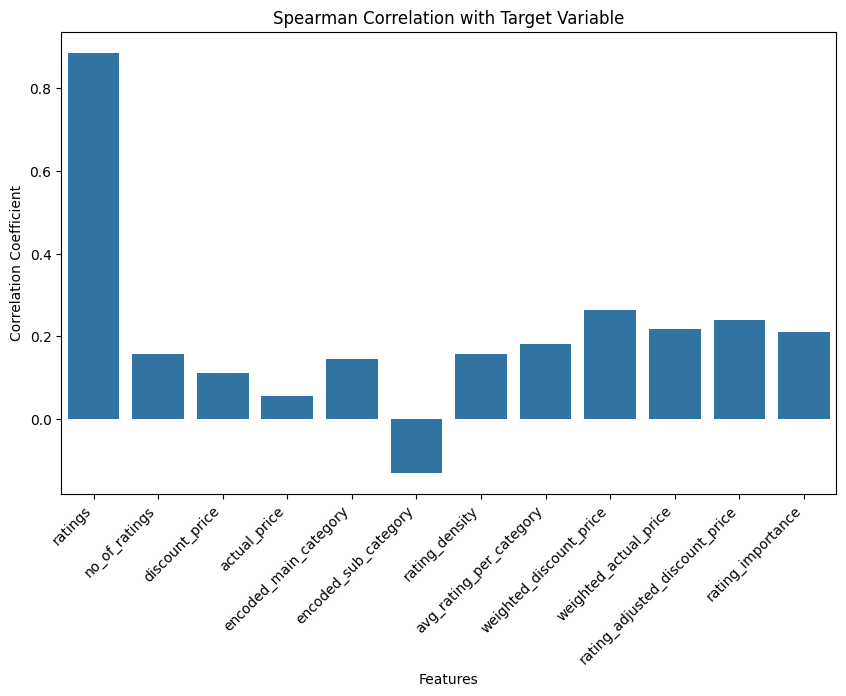

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate Spearman correlation
corr_with_target = df.drop(['int_rating', 'product', 'link', 'main_category', 'sub_category'], axis=1).corrwith(df['int_rating'], method='spearman')
# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
plt.title('Spearman Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
df.to_excel(os.path.join(exp_dir, 'Train_Data_3_classes_encoded.xlsx'), index=False)

In [11]:
df.columns

Index(['product', 'main_category', 'sub_category', 'link', 'ratings',
       'no_of_ratings', 'discount_price', 'actual_price', 'int_rating',
       'encoded_main_category', 'encoded_sub_category', 'rating_density',
       'avg_rating_per_category', 'weighted_discount_price',
       'weighted_actual_price', 'rating_adjusted_discount_price',
       'rating_importance'],
      dtype='object')

In [12]:

# Optional: Process the 'link' column if necessary or drop it
# df = train_df.drop(columns=['link'])

# Step 2: Normalize numerical columns
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
# df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
#     'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
#     'weighted_actual_price', 'rating_adjusted_discount_price',
#     'main_category_rating_importance',
#     'sub_category_rating_importance', 'rating_importance']] = scaler.fit_transform(df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
#                                                                                        'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
#                                                                                        'weighted_actual_price', 'rating_adjusted_discount_price',
#                                                                                        'main_category_rating_importance','sub_category_rating_importance', 'rating_importance']])

df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
    'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
    'weighted_actual_price', 'rating_adjusted_discount_price',
    'rating_importance']] = scaler.fit_transform(df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
                                                                                       'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
                                                                                       'weighted_actual_price', 'rating_adjusted_discount_price','rating_importance']])


In [13]:
# Features and target
# X = df[['encoded_main_category', 'encoded_sub_category', 'ratings', 'no_of_ratings', 'actual_price', 'discount_price']]
# y = df['int_rating']

X = df.drop(columns=['int_rating', 'product', 'link', 'main_category', 'sub_category', 'ratings'])
y = df['int_rating']

# Stratified split to maintain the distribution of int_rating across train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine features and target back into DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)


In [14]:
train_df.to_excel(os.path.join(exp_dir,'encoded_train_data.xlsx'), index=False)

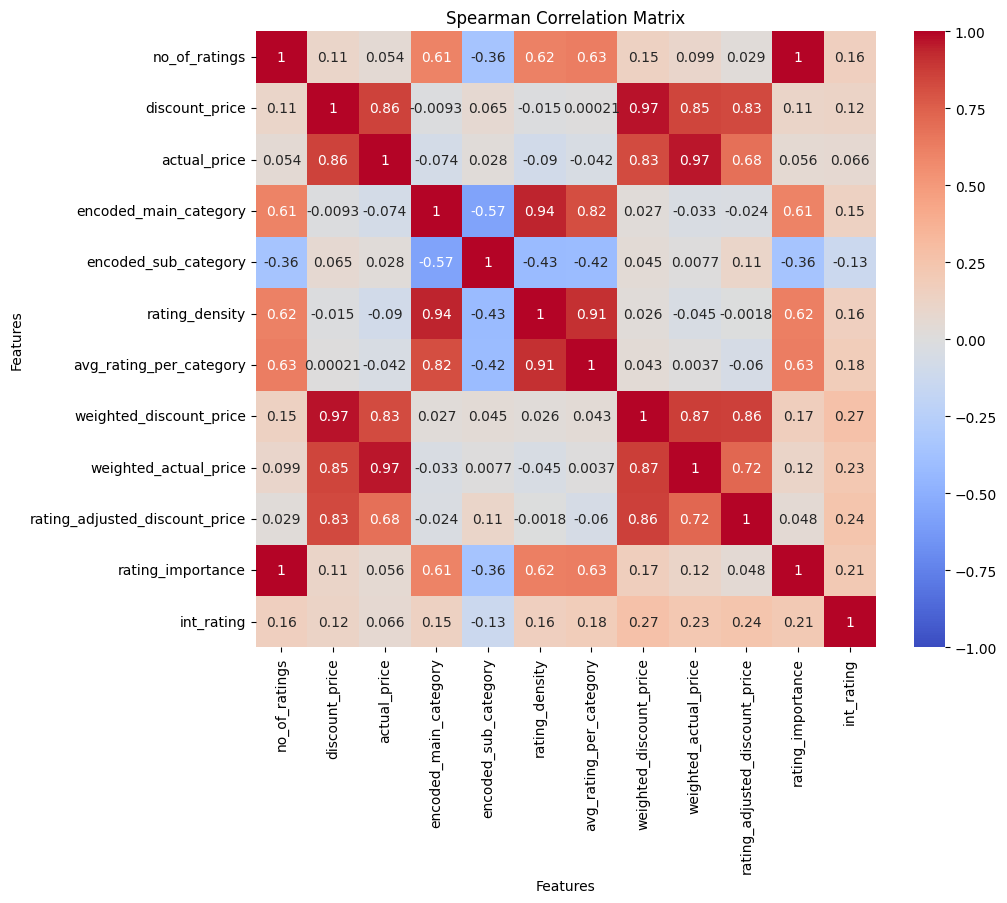

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Spearman correlation
corr_matrix = train_df.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [16]:
class CustomDataset(Dataset):
    def __init__(self, df, feature_cols, target_col):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        features = torch.tensor(self.df[self.feature_cols].iloc[idx].values)
        target = torch.tensor(self.df[self.target_col].iloc[idx])
        return features, target

In [17]:
feature_cols = train_df.columns.drop(['int_rating']).tolist()
target_col = 'int_rating'

train_dataset = CustomDataset(train_df, feature_cols, target_col)
val_dataset = CustomDataset(val_df, feature_cols, target_col)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
feature_cols

['no_of_ratings',
 'discount_price',
 'actual_price',
 'encoded_main_category',
 'encoded_sub_category',
 'rating_density',
 'avg_rating_per_category',
 'weighted_discount_price',
 'weighted_actual_price',
 'rating_adjusted_discount_price',
 'rating_importance']

### Model and Dataset class Definition

In [17]:
# class RecommendationModel(nn.Module):
#     def __init__(self, input_dim):
#         super(RecommendationModel, self).__init__()
        
#         self.fc1 = nn.Linear(input_dim, 512)
        
#         self.fc2 = nn.Linear(512, 512)
        
#         self.fc3 = nn.Linear(512, 256)
        
#         self.fc4 = nn.Linear(256, 256)
        
#         self.fc5 = nn.Linear(256, 128)
        
#         self.fc6 = nn.Linear(128, 128)
        
#         self.fc7 = nn.Linear(128, 64)
        
#         self.fc8 = nn.Linear(64, 64)
        
#         self.fc9 = nn.Linear(64, 3)
        
#     def forward(self, features):
#         x = torch.relu(self.fc1(features))
#         x = x + torch.relu(self.fc2(x))  # Residual connection
#         x = torch.relu(self.fc3(x))
#         x = x + torch.relu(self.fc4(x))  # Residual connection
#         x = torch.relu(self.fc5(x))
#         x = x + torch.relu(self.fc6(x))  # Residual connection
#         x = torch.relu(self.fc7(x))
#         x = x + torch.relu(self.fc8(x))  # Residual connection
#         output = self.fc9(x)
#         return output

class RecommendationModel(nn.Module):
    def __init__(self, input_dim):
        super(RecommendationModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.fc4 = nn.Linear(64, 32)
        self.dropout4 = nn.Dropout(p=0.3)
        
        self.fc5 = nn.Linear(32, 3)
        
    def forward(self, features):
        x = torch.relu(self.fc1(features))
        x = self.dropout1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        
        output = self.fc5(x)
        return output

In [18]:
# Initialize metrics trackers
def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    return accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())

def compute_auc(predictions, labels, num_classes):
    predictions_prob = F.softmax(predictions, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    if num_classes == 2:
        return roc_auc_score(labels, predictions_prob[:, 1])  # For binary classification
    else:
        return roc_auc_score(labels, predictions_prob, multi_class='ovr')  # For multi-class classification
    
def logging(log_path, log_text):
    with open(log_path, 'a') as file:
        file.write(log_text + '\n')
        

def calculate_average_auc(probs, labels, num_classes=3):
    # Detach tensors and convert them to NumPy arrays
    probs_np = probs.detach().numpy()
    labels_np = labels.detach().numpy()
    
    aucs = []
    labels_one_hot = F.one_hot(torch.tensor(labels_np), num_classes).numpy()  # Convert labels to one-hot encoding
    for i in range(num_classes):
        auc = roc_auc_score(labels_one_hot[:, i], probs_np[:, i])
        aucs.append(auc)
    return np.mean(aucs)  # Return the average AUC


def calculate_precision_f1(probs, labels, num_classes=3):
    # Detach tensors and convert them to NumPy arrays
    probs_np = probs.detach().numpy()
    labels_np = labels.detach().numpy()

    # Convert probabilities to predicted class labels
    preds = probs_np.argmax(axis=1)

    # Calculate precision and F1 score for each class
    precision = precision_score(labels_np, preds, average='weighted', zero_division=1)
    f1 = f1_score(labels_np, preds, average='weighted')
    
    return precision, f1


### Model initialization and Training parameters

In [19]:
# Initialize the model
# num_products = len(df['encoded_product'].unique())
# num_categories = len(df['encoded_main_category'].unique())
# num_subcategories = len(df['encoded_sub_category'].unique())
input_dim = len(train_df.columns) - 1
# model = RecommendationModel(num_products, num_categories, num_subcategories)
model = RecommendationModel(input_dim)

# Define loss function
criterion = nn.CrossEntropyLoss()  # Since it's a multi-class classification problem
# criterion = nn.BCEWithLogitsLoss()  # Since it's a multi-class classification problem

# Define Optimizer and Scheduler and Learning Rate
# {'learning_rate': 0.00047307239371176485, 'weight_decay': 0.0002572176180532664, 'dropout_rate': 0.1475648189305909, 'embedding_dim': 10}

num_epochs = 200
initial_lr = 0.001
exponent = 0.98
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=3e-3)
scheduler = ExponentialLR(optimizer, gamma=exponent)

In [20]:
print(model)

RecommendationModel(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=32, out_features=3, bias=True)
)


### Training and Validation Loop

In [21]:
import torch
import torch.nn.functional as F
import time
import numpy as np
import pandas as pd
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move model to the appropriate device
model = model.to(device)

# Initialize best validation loss
best_val_loss = float('inf')

# Variable to store probabilities when the best model is saved
best_epoch_train_probs = None
best_epoch_train_labels = None
best_epoch_val_probs = None
best_epoch_val_labels = None

epoch_count = 0

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}/{num_epochs}')
    
    start_time = time.time()  # Start epoch timer
    
    model.train()  # Set model to training mode
    running_loss = 0.0
    train_probs = []
    train_label_list = []
    
    # Training loop
    for batch in train_loader:
        tr_features, tr_labels= batch
        
        tr_features = tr_features.to(device).float()
        tr_labels = tr_labels.to(device)
        
        
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = model(tr_features)

        loss = criterion(outputs, tr_labels)  # Compute loss
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        train_probs.append(probs.cpu())
        train_label_list.append(tr_labels.cpu())
    
    # Calculate training metrics
    train_probs = torch.cat(train_probs)
    train_labels = torch.cat(train_label_list)
    train_loss = running_loss / len(train_loader)
    train_accuracy = (train_probs.argmax(dim=1) == train_labels).float().mean().item()
    train_precision, train_f1 = calculate_precision_f1(train_probs, train_labels)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_probs = []
    val_label_list = []
    with torch.no_grad():  # Disable gradient computation
        for batch in val_loader:
            v_features, v_labels= batch
                        
            v_features = v_features.to(device).float()
            v_labels = v_labels.to(device)
                        
            outputs = model(v_features)
            loss = criterion(outputs, v_labels)
            val_loss += loss.item()
            
            # Apply softmax to get probabilities
            probs = F.softmax(outputs, dim=1)
            val_probs.append(probs.cpu())
            val_label_list.append(v_labels.cpu())
    
    # Calculate validation metrics
    val_probs = torch.cat(val_probs)
    val_labels = torch.cat(val_label_list)
    val_loss = val_loss / len(val_loader)
    val_accuracy = (val_probs.argmax(dim=1) == val_labels).float().mean().item()
    val_precision, val_f1 = calculate_precision_f1(val_probs, val_labels)

    # Calculate epoch time
    epoch_time = time.time() - start_time
    
    # Learning rate
    lr = optimizer.param_groups[0]['lr']
    
    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Train Accuracy: {train_accuracy:.4f} | '
          f'Val Accuracy: {val_accuracy:.4f} | '
          f'Train Precision: {train_precision:.4f} | '
          f'Val Precision: {val_precision:.4f} | '
          f'Train F1: {train_f1:.4f} | '
          f'Val F1: {val_f1:.4f} | '
          f'Epoch Time: {epoch_time:.2f}s | '
          f'Learning Rate: {lr:.6f}')
    
    # Learning rate scheduler step
    scheduler.step()
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(weights_dir,'best_model.pth'))
        print(f'\nSaved new best model with Val_Loss: {val_loss:.3f}\n')
        epoch_count = 0
        
        # Store the probabilities of the best epoch
        best_epoch_train_probs = train_probs.detach().numpy()
        best_epoch_train_labels = train_labels.detach().numpy()
        best_epoch_val_probs = val_probs.detach().numpy()
        best_epoch_val_labels = val_labels.detach().numpy()
        
    if epoch_count == 15:
        print(f'Validation loss has not improved for {epoch_count} epochs. Training Finished !!!')
        break
    epoch_count += 1

# After training, save the probabilities of the best epoch
if best_epoch_train_probs is not None:
    train_prob_df = pd.DataFrame(best_epoch_train_probs, columns=[f'prob_class_{i}' for i in range(best_epoch_train_probs.shape[1])])
    train_prob_df['labels'] = best_epoch_train_labels

    val_prob_df = pd.DataFrame(best_epoch_val_probs, columns=[f'prob_class_{i}' for i in range(best_epoch_val_probs.shape[1])])
    val_prob_df['labels'] = best_epoch_val_labels

    # Save dataframes to Excel
    train_prob_df.to_excel(os.path.join(exp_dir,'best_epoch_train_data.xlsx'), index=False)
    val_prob_df.to_excel(os.path.join(exp_dir,'best_epoch_val_data.xlsx'), index=False)

print('Training Complete !!!')


Using device: cuda
Epoch: 1/200
Epoch [1/200] | Train Loss: 0.8363 | Val Loss: 0.8195 | Train Accuracy: 0.5366 | Val Accuracy: 0.5371 | Train Precision: 0.5569 | Val Precision: 0.6153 | Train F1: 0.5222 | Val F1: 0.4473 | Epoch Time: 20.83s | Learning Rate: 0.001000

Saved new best model with Val_Loss: 0.820

Epoch: 2/200
Epoch [2/200] | Train Loss: 0.8106 | Val Loss: 0.7898 | Train Accuracy: 0.5657 | Val Accuracy: 0.5535 | Train Precision: 0.5883 | Val Precision: 0.6325 | Train F1: 0.5474 | Val F1: 0.4786 | Epoch Time: 20.91s | Learning Rate: 0.000980

Saved new best model with Val_Loss: 0.790

Epoch: 3/200
Epoch [3/200] | Train Loss: 0.7655 | Val Loss: 0.6741 | Train Accuracy: 0.5980 | Val Accuracy: 0.6587 | Train Precision: 0.6181 | Val Precision: 0.6931 | Train F1: 0.5827 | Val F1: 0.6366 | Epoch Time: 20.65s | Learning Rate: 0.000960

Saved new best model with Val_Loss: 0.674

Epoch: 4/200
Epoch [4/200] | Train Loss: 0.6676 | Val Loss: 0.6058 | Train Accuracy: 0.6699 | Val Accurac

# ---------------------------------------------------

# grid search

In [17]:
import torch
import torch.nn.functional as F
import time

def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, num_epochs, scheduler=None, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Move model to the appropriate device
    model = model.to(device)

    # Initialize best validation loss
    best_val_loss = float('inf')
    epoch_count = 0

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch + 1}/{num_epochs}')
        
        start_time = time.time()  # Start epoch timer
        
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Training loop
        for batch in train_loader:
            category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price, labels = batch
            
            # Move data to the appropriate device
            category_id, subcategory_id = category_id.to(device), subcategory_id.to(device)
            ratings, no_of_ratings = ratings.to(device), no_of_ratings.to(device)
            actual_price, discount_price = actual_price.to(device), discount_price.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type Long
            
            optimizer.zero_grad()  # Clear gradients
            
            # Forward pass
            outputs = model(category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price)
            loss = criterion(outputs, labels)  # Compute loss
            
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
        
        # Calculate average training loss
        train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient computation
            for batch in val_loader:
                category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price, labels = batch
                
                # Move data to the appropriate device
                category_id, subcategory_id = category_id.to(device), subcategory_id.to(device)
                ratings, no_of_ratings = ratings.to(device), no_of_ratings.to(device)
                actual_price, discount_price = actual_price.to(device), discount_price.to(device)
                labels = labels.to(device).long()  # Ensure labels are of type Long
                
                outputs = model(category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Calculate average validation loss
        val_loss = val_loss / len(val_loader)
        
        # Calculate epoch time
        epoch_time = time.time() - start_time
        
        # Print metrics
        print(f'Epoch [{epoch+1}/{num_epochs}] | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Epoch Time: {epoch_time:.2f}s')
        
        # Learning rate scheduler step
        if scheduler is not None:
            scheduler.step()
        
        # Save the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epoch_count = 0
        else:
            epoch_count += 1
            
        if epoch_count == 30:  # Early stopping if no improvement for 30 epochs
            print(f'Validation loss has not improved for {epoch_count} epochs. Training Finished !!!')
            break

    print('Training Complete !!!')
    return best_val_loss


In [20]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    embedding_dim = trial.suggest_categorical('embedding_dim', [10, 50, 100])
    
    # Define your model, optimizer, and loss function here
    model = RecommendationModel(num_categories, num_subcategories, embedding_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    
    # Train your model and evaluate performance on validation data
    best_val_loss = train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, num_epochs=10)

    
    return best_val_loss  # or return -val_accuracy for maximization

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_params)


[I 2024-08-27 02:01:24,069] A new study created in memory with name: no-name-aa940287-c29c-41bb-89b5-f5ca29822957
C:\Users\MKK_Forschung\AppData\Local\Temp\ipykernel_47776\2612128501.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\MKK_Forschung\AppData\Local\Temp\ipykernel_47776\2612128501.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
C:\Users\MKK_Forschung\AppData\Local\Temp\ipykernel_47776\2612128501.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See htt

Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.9369 | Val Loss: 0.8502 | Epoch Time: 2.21s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.8076 | Val Loss: 0.6828 | Epoch Time: 2.40s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.6098 | Val Loss: 0.3728 | Epoch Time: 2.35s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.4148 | Val Loss: 0.2159 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.2996 | Val Loss: 0.1364 | Epoch Time: 2.78s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.2230 | Val Loss: 0.0884 | Epoch Time: 2.75s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.1699 | Val Loss: 0.0583 | Epoch Time: 2.81s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.1298 | Val Loss: 0.0384 | Epoch Time: 2.77s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.1030 | Val Loss: 0.0282 | Epoch Time: 2.75s
Epoch: 10/10


[I 2024-08-27 02:01:49,934] Trial 0 finished with value: 0.020509958700326982 and parameters: {'learning_rate': 0.00010562957598235742, 'weight_decay': 0.000289592173040625, 'dropout_rate': 0.3119535187412517, 'embedding_dim': 100}. Best is trial 0 with value: 0.020509958700326982.


Epoch [10/10] | Train Loss: 0.0818 | Val Loss: 0.0205 | Epoch Time: 2.73s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 1.0303 | Val Loss: 1.0182 | Epoch Time: 2.61s
Epoch: 2/10
Epoch [2/10] | Train Loss: 1.0122 | Val Loss: 1.0016 | Epoch Time: 2.71s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.9925 | Val Loss: 0.9761 | Epoch Time: 2.64s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.9624 | Val Loss: 0.9343 | Epoch Time: 2.66s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.9178 | Val Loss: 0.8802 | Epoch Time: 2.61s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.8711 | Val Loss: 0.8273 | Epoch Time: 2.65s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.8355 | Val Loss: 0.7906 | Epoch Time: 2.61s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.8093 | Val Loss: 0.7617 | Epoch Time: 2.63s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.7817 | Val Loss: 0.7317 | Epoch Time: 2.64s
Epoch: 10/10


[I 2024-08-27 02:02:16,364] Trial 1 finished with value: 0.6969261852002913 and parameters: {'learning_rate': 1.6159744329215897e-05, 'weight_decay': 1.8658325362002914e-05, 'dropout_rate': 0.4963088784095999, 'embedding_dim': 100}. Best is trial 0 with value: 0.020509958700326982.


Epoch [10/10] | Train Loss: 0.7605 | Val Loss: 0.6969 | Epoch Time: 2.67s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 1.0421 | Val Loss: 1.0324 | Epoch Time: 2.66s
Epoch: 2/10
Epoch [2/10] | Train Loss: 1.0174 | Val Loss: 1.0025 | Epoch Time: 2.65s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.9810 | Val Loss: 0.9608 | Epoch Time: 2.63s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.9397 | Val Loss: 0.9076 | Epoch Time: 2.63s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.8956 | Val Loss: 0.8602 | Epoch Time: 2.66s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.8569 | Val Loss: 0.8222 | Epoch Time: 2.67s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.8279 | Val Loss: 0.7931 | Epoch Time: 2.61s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.8052 | Val Loss: 0.7702 | Epoch Time: 2.68s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.7850 | Val Loss: 0.7493 | Epoch Time: 2.65s
Epoch: 10/10


[I 2024-08-27 02:02:42,764] Trial 2 finished with value: 0.7293243219134629 and parameters: {'learning_rate': 1.2689166795973887e-05, 'weight_decay': 0.0006759529695548365, 'dropout_rate': 0.2031107322958913, 'embedding_dim': 50}. Best is trial 0 with value: 0.020509958700326982.


Epoch [10/10] | Train Loss: 0.7685 | Val Loss: 0.7293 | Epoch Time: 2.56s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.9472 | Val Loss: 0.7865 | Epoch Time: 2.54s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.7112 | Val Loss: 0.4968 | Epoch Time: 2.56s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.4833 | Val Loss: 0.2692 | Epoch Time: 2.54s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.3301 | Val Loss: 0.1508 | Epoch Time: 2.64s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.2341 | Val Loss: 0.0921 | Epoch Time: 2.53s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.1793 | Val Loss: 0.0624 | Epoch Time: 2.61s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.1406 | Val Loss: 0.0423 | Epoch Time: 2.56s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.1112 | Val Loss: 0.0260 | Epoch Time: 2.63s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0895 | Val Loss: 0.0191 | Epoch Time: 2.20s
Epoch: 10/10


[I 2024-08-27 02:03:07,807] Trial 3 finished with value: 0.017439396466098486 and parameters: {'learning_rate': 0.00010045004346993516, 'weight_decay': 2.0393872699543215e-05, 'dropout_rate': 0.46642050650031097, 'embedding_dim': 50}. Best is trial 3 with value: 0.017439396466098486.


Epoch [10/10] | Train Loss: 0.0749 | Val Loss: 0.0174 | Epoch Time: 2.24s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 1.0351 | Val Loss: 0.9309 | Epoch Time: 2.23s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.8084 | Val Loss: 0.6433 | Epoch Time: 2.25s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.6032 | Val Loss: 0.4600 | Epoch Time: 2.22s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.4820 | Val Loss: 0.3229 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.3831 | Val Loss: 0.2220 | Epoch Time: 2.32s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.3041 | Val Loss: 0.1528 | Epoch Time: 2.28s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.2391 | Val Loss: 0.1016 | Epoch Time: 2.21s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.1976 | Val Loss: 0.0758 | Epoch Time: 3.08s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.1722 | Val Loss: 0.0605 | Epoch Time: 3.37s
Epoch: 10/10


[I 2024-08-27 02:03:33,599] Trial 4 finished with value: 0.04853408059646045 and parameters: {'learning_rate': 7.15080976833921e-05, 'weight_decay': 0.0002652587328103737, 'dropout_rate': 0.13884240743713688, 'embedding_dim': 10}. Best is trial 3 with value: 0.017439396466098486.


Epoch [10/10] | Train Loss: 0.1508 | Val Loss: 0.0485 | Epoch Time: 3.50s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 1.0202 | Val Loss: 0.7741 | Epoch Time: 3.38s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.7114 | Val Loss: 0.5342 | Epoch Time: 3.40s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.5349 | Val Loss: 0.3437 | Epoch Time: 3.44s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.4019 | Val Loss: 0.2265 | Epoch Time: 3.41s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.3187 | Val Loss: 0.1582 | Epoch Time: 3.45s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.2618 | Val Loss: 0.1171 | Epoch Time: 3.50s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.2236 | Val Loss: 0.0883 | Epoch Time: 3.43s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.1946 | Val Loss: 0.0685 | Epoch Time: 3.44s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.1681 | Val Loss: 0.0543 | Epoch Time: 3.46s
Epoch: 10/10


[I 2024-08-27 02:04:08,055] Trial 5 finished with value: 0.043829770463328525 and parameters: {'learning_rate': 8.33524983711373e-05, 'weight_decay': 0.00041250724337982503, 'dropout_rate': 0.46726426932482723, 'embedding_dim': 10}. Best is trial 3 with value: 0.017439396466098486.


Epoch [10/10] | Train Loss: 0.1499 | Val Loss: 0.0438 | Epoch Time: 3.53s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5242 | Val Loss: 0.0830 | Epoch Time: 3.62s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1366 | Val Loss: 0.0397 | Epoch Time: 3.56s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0903 | Val Loss: 0.0220 | Epoch Time: 3.51s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0779 | Val Loss: 0.0233 | Epoch Time: 3.49s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0638 | Val Loss: 0.0432 | Epoch Time: 3.14s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0537 | Val Loss: 0.0106 | Epoch Time: 2.22s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0440 | Val Loss: 0.0118 | Epoch Time: 2.20s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0365 | Val Loss: 0.0190 | Epoch Time: 2.24s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0358 | Val Loss: 0.0130 | Epoch Time: 2.24s
Epoch: 10/10


[I 2024-08-27 02:04:36,542] Trial 6 finished with value: 0.010608071051049797 and parameters: {'learning_rate': 0.0013494612702106877, 'weight_decay': 4.833582743361429e-05, 'dropout_rate': 0.32411321536979343, 'embedding_dim': 100}. Best is trial 6 with value: 0.010608071051049797.


Epoch [10/10] | Train Loss: 0.0338 | Val Loss: 0.0937 | Epoch Time: 2.26s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4203 | Val Loss: 0.0923 | Epoch Time: 2.25s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1261 | Val Loss: 0.0457 | Epoch Time: 2.20s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0709 | Val Loss: 0.0192 | Epoch Time: 2.23s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0560 | Val Loss: 0.0237 | Epoch Time: 2.23s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0468 | Val Loss: 0.0127 | Epoch Time: 2.24s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0473 | Val Loss: 0.0426 | Epoch Time: 2.22s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0377 | Val Loss: 0.0086 | Epoch Time: 2.25s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0276 | Val Loss: 0.0082 | Epoch Time: 2.22s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0257 | Val Loss: 0.0095 | Epoch Time: 2.23s
Epoch: 10/10


[I 2024-08-27 02:04:58,842] Trial 7 finished with value: 0.008174357079100915 and parameters: {'learning_rate': 0.0019670874265759423, 'weight_decay': 7.364732309918615e-05, 'dropout_rate': 0.37242835482197756, 'embedding_dim': 100}. Best is trial 7 with value: 0.008174357079100915.


Epoch [10/10] | Train Loss: 0.0215 | Val Loss: 0.0126 | Epoch Time: 2.22s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2038 | Val Loss: 0.0193 | Epoch Time: 2.27s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0522 | Val Loss: 0.0236 | Epoch Time: 2.24s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0474 | Val Loss: 0.0209 | Epoch Time: 2.23s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0486 | Val Loss: 0.0198 | Epoch Time: 2.20s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0465 | Val Loss: 0.0154 | Epoch Time: 2.21s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0450 | Val Loss: 0.0238 | Epoch Time: 2.22s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0418 | Val Loss: 0.0177 | Epoch Time: 2.19s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0395 | Val Loss: 0.0116 | Epoch Time: 2.21s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0391 | Val Loss: 0.0091 | Epoch Time: 2.22s
Epoch: 10/10


[I 2024-08-27 02:05:21,080] Trial 8 finished with value: 0.009098814622629233 and parameters: {'learning_rate': 0.0025998655131711087, 'weight_decay': 0.0033943396741760276, 'dropout_rate': 0.41472363976351223, 'embedding_dim': 10}. Best is trial 7 with value: 0.008174357079100915.


Epoch [10/10] | Train Loss: 0.0390 | Val Loss: 0.0166 | Epoch Time: 2.23s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3560 | Val Loss: 0.0479 | Epoch Time: 2.25s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0576 | Val Loss: 0.0191 | Epoch Time: 2.20s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0420 | Val Loss: 0.0185 | Epoch Time: 2.20s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0363 | Val Loss: 0.0110 | Epoch Time: 2.21s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0320 | Val Loss: 0.0183 | Epoch Time: 2.24s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0302 | Val Loss: 0.0186 | Epoch Time: 2.20s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0287 | Val Loss: 0.0146 | Epoch Time: 2.24s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0258 | Val Loss: 0.0104 | Epoch Time: 2.27s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0266 | Val Loss: 0.0078 | Epoch Time: 2.27s
Epoch: 10/10


[I 2024-08-27 02:05:43,411] Trial 9 finished with value: 0.007788043300122378 and parameters: {'learning_rate': 0.0012493258966219426, 'weight_decay': 0.0016894579600223029, 'dropout_rate': 0.43299503513824733, 'embedding_dim': 50}. Best is trial 9 with value: 0.007788043300122378.


Epoch [10/10] | Train Loss: 0.0253 | Val Loss: 0.0134 | Epoch Time: 2.26s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2234 | Val Loss: 0.0711 | Epoch Time: 2.34s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0927 | Val Loss: 0.0657 | Epoch Time: 2.36s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0888 | Val Loss: 0.0419 | Epoch Time: 2.31s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0932 | Val Loss: 0.1481 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0893 | Val Loss: 0.0434 | Epoch Time: 2.32s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0887 | Val Loss: 0.0525 | Epoch Time: 2.31s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0834 | Val Loss: 0.0339 | Epoch Time: 2.32s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0875 | Val Loss: 0.0471 | Epoch Time: 2.34s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0874 | Val Loss: 0.0389 | Epoch Time: 2.30s
Epoch: 10/10


[I 2024-08-27 02:06:06,634] Trial 10 finished with value: 0.033903788364622545 and parameters: {'learning_rate': 0.009024814057342088, 'weight_decay': 0.009921214886711662, 'dropout_rate': 0.2179574984453195, 'embedding_dim': 50}. Best is trial 9 with value: 0.007788043300122378.


Epoch [10/10] | Train Loss: 0.0919 | Val Loss: 0.0522 | Epoch Time: 2.30s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4725 | Val Loss: 0.0746 | Epoch Time: 2.23s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0928 | Val Loss: 0.0151 | Epoch Time: 2.22s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0553 | Val Loss: 0.0155 | Epoch Time: 2.21s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0453 | Val Loss: 0.0082 | Epoch Time: 2.20s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0334 | Val Loss: 0.0095 | Epoch Time: 2.19s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0330 | Val Loss: 0.0087 | Epoch Time: 2.18s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0274 | Val Loss: 0.0103 | Epoch Time: 2.20s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0273 | Val Loss: 0.0062 | Epoch Time: 2.25s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0246 | Val Loss: 0.0155 | Epoch Time: 2.19s
Epoch: 10/10


[I 2024-08-27 02:06:28,732] Trial 11 finished with value: 0.006220188043962773 and parameters: {'learning_rate': 0.0009292908424582042, 'weight_decay': 0.001186952136817461, 'dropout_rate': 0.3751717641485347, 'embedding_dim': 50}. Best is trial 11 with value: 0.006220188043962773.


Epoch [10/10] | Train Loss: 0.0229 | Val Loss: 0.0094 | Epoch Time: 2.23s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4726 | Val Loss: 0.1192 | Epoch Time: 2.22s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0992 | Val Loss: 0.0214 | Epoch Time: 2.24s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0465 | Val Loss: 0.0144 | Epoch Time: 2.23s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0370 | Val Loss: 0.0137 | Epoch Time: 2.24s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0318 | Val Loss: 0.0105 | Epoch Time: 2.18s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0297 | Val Loss: 0.0142 | Epoch Time: 2.21s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0295 | Val Loss: 0.0090 | Epoch Time: 2.20s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0283 | Val Loss: 0.0100 | Epoch Time: 2.19s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0258 | Val Loss: 0.0086 | Epoch Time: 2.21s
Epoch: 10/10


[I 2024-08-27 02:06:50,878] Trial 12 finished with value: 0.008553036597419045 and parameters: {'learning_rate': 0.0007361865278592217, 'weight_decay': 0.0014866829890175365, 'dropout_rate': 0.3886087389983241, 'embedding_dim': 50}. Best is trial 11 with value: 0.006220188043962773.


Epoch [10/10] | Train Loss: 0.0252 | Val Loss: 0.0094 | Epoch Time: 2.22s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.6563 | Val Loss: 0.1927 | Epoch Time: 2.30s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1643 | Val Loss: 0.0308 | Epoch Time: 2.23s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0744 | Val Loss: 0.0187 | Epoch Time: 2.18s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0476 | Val Loss: 0.0120 | Epoch Time: 2.24s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0426 | Val Loss: 0.0111 | Epoch Time: 2.23s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0401 | Val Loss: 0.0123 | Epoch Time: 2.21s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0335 | Val Loss: 0.0137 | Epoch Time: 2.14s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0340 | Val Loss: 0.0101 | Epoch Time: 2.20s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0313 | Val Loss: 0.0097 | Epoch Time: 2.19s
Epoch: 10/10


[I 2024-08-27 02:07:12,995] Trial 13 finished with value: 0.009677278544185482 and parameters: {'learning_rate': 0.00038630428424601834, 'weight_decay': 0.002390813889571911, 'dropout_rate': 0.4186222564335113, 'embedding_dim': 50}. Best is trial 11 with value: 0.006220188043962773.


Epoch [10/10] | Train Loss: 0.0303 | Val Loss: 0.0113 | Epoch Time: 2.19s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2281 | Val Loss: 0.0325 | Epoch Time: 2.26s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0771 | Val Loss: 0.0393 | Epoch Time: 2.21s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0710 | Val Loss: 0.0331 | Epoch Time: 2.21s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0682 | Val Loss: 0.0263 | Epoch Time: 2.21s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0672 | Val Loss: 0.0311 | Epoch Time: 2.17s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0653 | Val Loss: 0.0278 | Epoch Time: 2.17s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0678 | Val Loss: 0.0589 | Epoch Time: 2.19s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0708 | Val Loss: 0.0297 | Epoch Time: 2.21s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0643 | Val Loss: 0.0238 | Epoch Time: 2.20s
Epoch: 10/10


[I 2024-08-27 02:07:35,393] Trial 14 finished with value: 0.023788819672860284 and parameters: {'learning_rate': 0.0062400712799435985, 'weight_decay': 0.0068237581477349095, 'dropout_rate': 0.34733086664921575, 'embedding_dim': 50}. Best is trial 11 with value: 0.006220188043962773.


Epoch [10/10] | Train Loss: 0.0690 | Val Loss: 0.0299 | Epoch Time: 2.57s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7554 | Val Loss: 0.2408 | Epoch Time: 2.48s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.2176 | Val Loss: 0.0466 | Epoch Time: 2.55s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0944 | Val Loss: 0.0216 | Epoch Time: 2.64s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0585 | Val Loss: 0.0105 | Epoch Time: 2.63s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0426 | Val Loss: 0.0104 | Epoch Time: 2.66s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0331 | Val Loss: 0.0107 | Epoch Time: 2.62s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0269 | Val Loss: 0.0072 | Epoch Time: 2.60s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0270 | Val Loss: 0.0063 | Epoch Time: 2.66s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0252 | Val Loss: 0.0082 | Epoch Time: 2.62s
Epoch: 10/10


[I 2024-08-27 02:08:01,572] Trial 15 finished with value: 0.006307462766242053 and parameters: {'learning_rate': 0.00036492282440902824, 'weight_decay': 0.0007996090080089972, 'dropout_rate': 0.24606338835340505, 'embedding_dim': 50}. Best is trial 11 with value: 0.006220188043962773.


Epoch [10/10] | Train Loss: 0.0244 | Val Loss: 0.0068 | Epoch Time: 2.69s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7771 | Val Loss: 0.3860 | Epoch Time: 2.74s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.2752 | Val Loss: 0.0806 | Epoch Time: 2.71s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.1284 | Val Loss: 0.0302 | Epoch Time: 2.64s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0743 | Val Loss: 0.0158 | Epoch Time: 2.62s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0511 | Val Loss: 0.0117 | Epoch Time: 2.66s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0399 | Val Loss: 0.0116 | Epoch Time: 2.70s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0308 | Val Loss: 0.0071 | Epoch Time: 2.68s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0274 | Val Loss: 0.0063 | Epoch Time: 2.65s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0260 | Val Loss: 0.0088 | Epoch Time: 2.66s
Epoch: 10/10


[I 2024-08-27 02:08:28,302] Trial 16 finished with value: 0.00632432877491053 and parameters: {'learning_rate': 0.00028503395300751965, 'weight_decay': 0.0007879309245198366, 'dropout_rate': 0.25729186350224653, 'embedding_dim': 50}. Best is trial 11 with value: 0.006220188043962773.


Epoch [10/10] | Train Loss: 0.0251 | Val Loss: 0.0078 | Epoch Time: 2.65s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7743 | Val Loss: 0.4307 | Epoch Time: 2.74s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.3196 | Val Loss: 0.0840 | Epoch Time: 2.74s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.1443 | Val Loss: 0.0336 | Epoch Time: 2.59s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0782 | Val Loss: 0.0165 | Epoch Time: 2.56s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0505 | Val Loss: 0.0096 | Epoch Time: 2.63s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0388 | Val Loss: 0.0070 | Epoch Time: 2.65s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0304 | Val Loss: 0.0056 | Epoch Time: 2.61s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0272 | Val Loss: 0.0058 | Epoch Time: 2.68s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0225 | Val Loss: 0.0049 | Epoch Time: 2.62s
Epoch: 10/10


[I 2024-08-27 02:08:54,686] Trial 17 finished with value: 0.0049137186959009715 and parameters: {'learning_rate': 0.00037638791792994077, 'weight_decay': 9.443191008391016e-05, 'dropout_rate': 0.25596179173798705, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0283 | Val Loss: 0.0057 | Epoch Time: 2.54s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2476 | Val Loss: 0.0280 | Epoch Time: 2.45s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0607 | Val Loss: 0.0397 | Epoch Time: 2.43s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0375 | Val Loss: 0.0228 | Epoch Time: 2.46s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0312 | Val Loss: 0.0133 | Epoch Time: 2.45s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0219 | Val Loss: 0.0090 | Epoch Time: 2.35s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0207 | Val Loss: 0.0106 | Epoch Time: 2.33s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0181 | Val Loss: 0.0079 | Epoch Time: 2.32s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0151 | Val Loss: 0.0101 | Epoch Time: 2.35s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0156 | Val Loss: 0.0086 | Epoch Time: 2.37s
Epoch: 10/10


[I 2024-08-27 02:09:18,515] Trial 18 finished with value: 0.006598479979030706 and parameters: {'learning_rate': 0.003709204287299474, 'weight_decay': 0.00011127944824139722, 'dropout_rate': 0.11859608504555447, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0127 | Val Loss: 0.0066 | Epoch Time: 2.31s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7333 | Val Loss: 0.4534 | Epoch Time: 2.34s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.3944 | Val Loss: 0.1775 | Epoch Time: 2.35s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.2294 | Val Loss: 0.0837 | Epoch Time: 2.33s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.1668 | Val Loss: 0.0491 | Epoch Time: 2.33s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.1205 | Val Loss: 0.0303 | Epoch Time: 2.32s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0960 | Val Loss: 0.0227 | Epoch Time: 2.32s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0792 | Val Loss: 0.0151 | Epoch Time: 2.31s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0688 | Val Loss: 0.0134 | Epoch Time: 2.32s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0563 | Val Loss: 0.0117 | Epoch Time: 2.30s
Epoch: 10/10


[I 2024-08-27 02:09:41,740] Trial 19 finished with value: 0.011614463500483263 and parameters: {'learning_rate': 0.00021538054460256987, 'weight_decay': 0.00013621375998289033, 'dropout_rate': 0.27551366179307546, 'embedding_dim': 10}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0492 | Val Loss: 0.0116 | Epoch Time: 2.30s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.9563 | Val Loss: 0.8707 | Epoch Time: 2.33s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.8308 | Val Loss: 0.7699 | Epoch Time: 2.32s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.7641 | Val Loss: 0.7091 | Epoch Time: 2.33s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.7053 | Val Loss: 0.6416 | Epoch Time: 2.32s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.6454 | Val Loss: 0.5714 | Epoch Time: 2.34s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.5858 | Val Loss: 0.4997 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.5309 | Val Loss: 0.4370 | Epoch Time: 2.32s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.4808 | Val Loss: 0.3842 | Epoch Time: 2.34s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.4362 | Val Loss: 0.3369 | Epoch Time: 2.32s
Epoch: 10/10


[I 2024-08-27 02:10:04,962] Trial 20 finished with value: 0.2974209585177001 and parameters: {'learning_rate': 3.632027312738742e-05, 'weight_decay': 3.9639957756065846e-05, 'dropout_rate': 0.15874985705339217, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.3962 | Val Loss: 0.2974 | Epoch Time: 2.30s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.6196 | Val Loss: 0.1123 | Epoch Time: 2.31s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1284 | Val Loss: 0.0241 | Epoch Time: 2.31s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0594 | Val Loss: 0.0148 | Epoch Time: 2.31s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0446 | Val Loss: 0.0108 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0348 | Val Loss: 0.0088 | Epoch Time: 2.32s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0323 | Val Loss: 0.0094 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0305 | Val Loss: 0.0092 | Epoch Time: 2.30s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0273 | Val Loss: 0.0085 | Epoch Time: 2.30s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0275 | Val Loss: 0.0085 | Epoch Time: 2.31s
Epoch: 10/10


[I 2024-08-27 02:10:28,045] Trial 21 finished with value: 0.008459858339397558 and parameters: {'learning_rate': 0.0004934996861845533, 'weight_decay': 0.0009122651458093245, 'dropout_rate': 0.23661685433949456, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0247 | Val Loss: 0.0115 | Epoch Time: 2.31s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4887 | Val Loss: 0.0684 | Epoch Time: 2.33s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1105 | Val Loss: 0.0193 | Epoch Time: 2.33s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0548 | Val Loss: 0.0152 | Epoch Time: 2.30s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0439 | Val Loss: 0.0143 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0378 | Val Loss: 0.0167 | Epoch Time: 2.31s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0326 | Val Loss: 0.0073 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0340 | Val Loss: 0.0080 | Epoch Time: 2.29s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0290 | Val Loss: 0.0056 | Epoch Time: 2.32s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0343 | Val Loss: 0.0074 | Epoch Time: 2.31s
Epoch: 10/10


[I 2024-08-27 02:10:51,165] Trial 22 finished with value: 0.005595560665247459 and parameters: {'learning_rate': 0.0006779228621256484, 'weight_decay': 0.00020694375290597635, 'dropout_rate': 0.18498356965183277, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0280 | Val Loss: 0.0068 | Epoch Time: 2.32s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4905 | Val Loss: 0.0777 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0964 | Val Loss: 0.0192 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0536 | Val Loss: 0.0166 | Epoch Time: 2.31s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0454 | Val Loss: 0.0702 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0355 | Val Loss: 0.0091 | Epoch Time: 2.30s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0344 | Val Loss: 0.0102 | Epoch Time: 2.32s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0388 | Val Loss: 0.0147 | Epoch Time: 2.32s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0349 | Val Loss: 0.0103 | Epoch Time: 2.31s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0332 | Val Loss: 0.0120 | Epoch Time: 2.31s
Epoch: 10/10


[I 2024-08-27 02:11:14,232] Trial 23 finished with value: 0.009075909813315863 and parameters: {'learning_rate': 0.0008807478986313402, 'weight_decay': 0.00016153032700362758, 'dropout_rate': 0.1902475012458476, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0270 | Val Loss: 0.0218 | Epoch Time: 2.30s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.8606 | Val Loss: 0.7638 | Epoch Time: 2.35s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.6506 | Val Loss: 0.3560 | Epoch Time: 2.33s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.3677 | Val Loss: 0.1543 | Epoch Time: 2.33s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.2212 | Val Loss: 0.0725 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.1493 | Val Loss: 0.0397 | Epoch Time: 2.32s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.1032 | Val Loss: 0.0252 | Epoch Time: 2.29s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0746 | Val Loss: 0.0155 | Epoch Time: 2.33s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0587 | Val Loss: 0.0131 | Epoch Time: 2.34s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0476 | Val Loss: 0.0142 | Epoch Time: 2.32s
Epoch: 10/10


[I 2024-08-27 02:11:37,455] Trial 24 finished with value: 0.011740144591522528 and parameters: {'learning_rate': 0.00018521500035191435, 'weight_decay': 1.0030688724755636e-05, 'dropout_rate': 0.28347437501492667, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0401 | Val Loss: 0.0117 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.6467 | Val Loss: 0.1311 | Epoch Time: 2.28s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1446 | Val Loss: 0.0282 | Epoch Time: 2.34s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0697 | Val Loss: 0.0202 | Epoch Time: 2.36s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0493 | Val Loss: 0.0158 | Epoch Time: 2.34s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0422 | Val Loss: 0.0098 | Epoch Time: 2.33s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0344 | Val Loss: 0.0094 | Epoch Time: 2.34s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0307 | Val Loss: 0.0133 | Epoch Time: 2.35s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0281 | Val Loss: 0.0121 | Epoch Time: 2.34s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0317 | Val Loss: 0.0135 | Epoch Time: 2.29s
Epoch: 10/10


[I 2024-08-27 02:12:00,761] Trial 25 finished with value: 0.008712026447654508 and parameters: {'learning_rate': 0.0006179621261351598, 'weight_decay': 0.00042132897539118395, 'dropout_rate': 0.18019633931215823, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0261 | Val Loss: 0.0087 | Epoch Time: 2.32s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5017 | Val Loss: 0.1179 | Epoch Time: 2.31s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1201 | Val Loss: 0.0250 | Epoch Time: 2.32s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0718 | Val Loss: 0.0156 | Epoch Time: 2.31s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0595 | Val Loss: 0.0144 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0494 | Val Loss: 0.0096 | Epoch Time: 2.31s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0445 | Val Loss: 0.0158 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0434 | Val Loss: 0.0061 | Epoch Time: 2.31s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0390 | Val Loss: 0.0141 | Epoch Time: 2.31s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0357 | Val Loss: 0.0071 | Epoch Time: 2.33s
Epoch: 10/10


[I 2024-08-27 02:12:23,872] Trial 26 finished with value: 0.006078647465103366 and parameters: {'learning_rate': 0.0012320679137982518, 'weight_decay': 7.978448299603688e-05, 'dropout_rate': 0.10233335368277638, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0233 | Val Loss: 0.0172 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3221 | Val Loss: 0.0249 | Epoch Time: 2.27s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0695 | Val Loss: 0.0228 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0384 | Val Loss: 0.0113 | Epoch Time: 2.28s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0335 | Val Loss: 0.0178 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0290 | Val Loss: 0.0196 | Epoch Time: 2.31s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0197 | Val Loss: 0.0216 | Epoch Time: 2.34s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0220 | Val Loss: 0.0132 | Epoch Time: 2.35s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0163 | Val Loss: 0.0128 | Epoch Time: 2.32s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0202 | Val Loss: 0.0076 | Epoch Time: 2.32s
Epoch: 10/10


[I 2024-08-27 02:12:46,966] Trial 27 finished with value: 0.007553130291266678 and parameters: {'learning_rate': 0.0035777137875069856, 'weight_decay': 6.326545523655814e-05, 'dropout_rate': 0.1175589900828227, 'embedding_dim': 50}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0158 | Val Loss: 0.0094 | Epoch Time: 2.31s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.8947 | Val Loss: 0.7730 | Epoch Time: 2.28s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.7538 | Val Loss: 0.6891 | Epoch Time: 2.26s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.6340 | Val Loss: 0.4532 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.4060 | Val Loss: 0.2099 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.2482 | Val Loss: 0.1023 | Epoch Time: 2.32s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.1628 | Val Loss: 0.0592 | Epoch Time: 2.32s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.1124 | Val Loss: 0.0374 | Epoch Time: 2.33s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0810 | Val Loss: 0.0237 | Epoch Time: 2.30s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0639 | Val Loss: 0.0163 | Epoch Time: 2.31s
Epoch: 10/10


[I 2024-08-27 02:13:09,995] Trial 28 finished with value: 0.0163363453253643 and parameters: {'learning_rate': 0.0001630855185792264, 'weight_decay': 0.00019597703721098956, 'dropout_rate': 0.10377971956414209, 'embedding_dim': 100}. Best is trial 17 with value: 0.0049137186959009715.


Epoch [10/10] | Train Loss: 0.0525 | Val Loss: 0.0167 | Epoch Time: 2.32s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3451 | Val Loss: 0.0268 | Epoch Time: 2.24s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0580 | Val Loss: 0.0063 | Epoch Time: 2.17s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0377 | Val Loss: 0.0100 | Epoch Time: 2.15s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0253 | Val Loss: 0.0107 | Epoch Time: 2.16s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0232 | Val Loss: 0.0246 | Epoch Time: 2.20s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0202 | Val Loss: 0.0088 | Epoch Time: 2.19s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0218 | Val Loss: 0.0038 | Epoch Time: 2.19s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0173 | Val Loss: 0.0066 | Epoch Time: 2.20s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0191 | Val Loss: 0.0070 | Epoch Time: 2.19s
Epoch: 10/10


[I 2024-08-27 02:13:31,913] Trial 29 finished with value: 0.003819821802764675 and parameters: {'learning_rate': 0.0014260236839837505, 'weight_decay': 9.791564210886598e-05, 'dropout_rate': 0.16360835321441344, 'embedding_dim': 10}. Best is trial 29 with value: 0.003819821802764675.


Epoch [10/10] | Train Loss: 0.0165 | Val Loss: 0.0087 | Epoch Time: 2.21s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2640 | Val Loss: 0.0312 | Epoch Time: 2.37s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0579 | Val Loss: 0.0171 | Epoch Time: 2.75s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0432 | Val Loss: 0.0152 | Epoch Time: 2.73s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0304 | Val Loss: 0.0065 | Epoch Time: 2.75s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0286 | Val Loss: 0.0068 | Epoch Time: 2.84s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0281 | Val Loss: 0.0094 | Epoch Time: 2.81s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0245 | Val Loss: 0.0134 | Epoch Time: 2.75s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0248 | Val Loss: 0.0078 | Epoch Time: 2.76s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0208 | Val Loss: 0.0071 | Epoch Time: 2.75s
Epoch: 10/10


[I 2024-08-27 02:13:59,235] Trial 30 finished with value: 0.006485728087926706 and parameters: {'learning_rate': 0.001839824572537461, 'weight_decay': 3.051919042087296e-05, 'dropout_rate': 0.1679391044134922, 'embedding_dim': 10}. Best is trial 29 with value: 0.003819821802764675.


Epoch [10/10] | Train Loss: 0.0205 | Val Loss: 0.0095 | Epoch Time: 2.79s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3184 | Val Loss: 0.0238 | Epoch Time: 2.76s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0652 | Val Loss: 0.0168 | Epoch Time: 2.67s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0424 | Val Loss: 0.0147 | Epoch Time: 2.70s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0328 | Val Loss: 0.0139 | Epoch Time: 2.64s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0270 | Val Loss: 0.0096 | Epoch Time: 2.60s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0253 | Val Loss: 0.0097 | Epoch Time: 2.62s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0212 | Val Loss: 0.0050 | Epoch Time: 2.64s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0204 | Val Loss: 0.0061 | Epoch Time: 2.67s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0192 | Val Loss: 0.0042 | Epoch Time: 2.66s
Epoch: 10/10


[I 2024-08-27 02:14:25,811] Trial 31 finished with value: 0.004219920686355963 and parameters: {'learning_rate': 0.0012363533415283854, 'weight_decay': 8.769073824257748e-05, 'dropout_rate': 0.14291045265665187, 'embedding_dim': 10}. Best is trial 29 with value: 0.003819821802764675.


Epoch [10/10] | Train Loss: 0.0213 | Val Loss: 0.0065 | Epoch Time: 2.61s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5325 | Val Loss: 0.1162 | Epoch Time: 2.69s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1635 | Val Loss: 0.0316 | Epoch Time: 2.79s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0888 | Val Loss: 0.0169 | Epoch Time: 2.77s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0571 | Val Loss: 0.0085 | Epoch Time: 2.52s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0443 | Val Loss: 0.0100 | Epoch Time: 2.68s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0357 | Val Loss: 0.0061 | Epoch Time: 2.62s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0304 | Val Loss: 0.0053 | Epoch Time: 2.67s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0251 | Val Loss: 0.0044 | Epoch Time: 2.60s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0244 | Val Loss: 0.0065 | Epoch Time: 2.64s
Epoch: 10/10


[I 2024-08-27 02:14:52,483] Trial 32 finished with value: 0.003094467500759688 and parameters: {'learning_rate': 0.00047307239371176485, 'weight_decay': 0.0002572176180532664, 'dropout_rate': 0.1475648189305909, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0192 | Val Loss: 0.0031 | Epoch Time: 2.69s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7421 | Val Loss: 0.3652 | Epoch Time: 2.50s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.2973 | Val Loss: 0.0880 | Epoch Time: 2.55s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.1574 | Val Loss: 0.0392 | Epoch Time: 2.55s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.1036 | Val Loss: 0.0199 | Epoch Time: 2.55s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0722 | Val Loss: 0.0149 | Epoch Time: 2.29s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0572 | Val Loss: 0.0105 | Epoch Time: 2.22s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0480 | Val Loss: 0.0092 | Epoch Time: 2.17s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0403 | Val Loss: 0.0075 | Epoch Time: 2.23s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0352 | Val Loss: 0.0070 | Epoch Time: 2.17s
Epoch: 10/10


[I 2024-08-27 02:15:15,923] Trial 33 finished with value: 0.007016204209761664 and parameters: {'learning_rate': 0.0003102430956169279, 'weight_decay': 0.00010696255522251537, 'dropout_rate': 0.1490623134306614, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0314 | Val Loss: 0.0074 | Epoch Time: 2.20s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 1.1558 | Val Loss: 1.0643 | Epoch Time: 2.27s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.9035 | Val Loss: 0.7851 | Epoch Time: 2.29s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.7628 | Val Loss: 0.7090 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.7021 | Val Loss: 0.6502 | Epoch Time: 2.30s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.6492 | Val Loss: 0.5819 | Epoch Time: 2.31s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.5840 | Val Loss: 0.4766 | Epoch Time: 2.31s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.4962 | Val Loss: 0.3645 | Epoch Time: 2.33s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.4208 | Val Loss: 0.2889 | Epoch Time: 2.37s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.3748 | Val Loss: 0.2410 | Epoch Time: 2.34s
Epoch: 10/10


[I 2024-08-27 02:15:39,079] Trial 34 finished with value: 0.20130375079730506 and parameters: {'learning_rate': 5.2724088910489585e-05, 'weight_decay': 0.0003747915074220714, 'dropout_rate': 0.21459654350000412, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.3324 | Val Loss: 0.2013 | Epoch Time: 2.33s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5180 | Val Loss: 0.1245 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1498 | Val Loss: 0.0317 | Epoch Time: 2.26s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0782 | Val Loss: 0.0156 | Epoch Time: 2.21s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0536 | Val Loss: 0.0115 | Epoch Time: 2.26s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0399 | Val Loss: 0.0092 | Epoch Time: 2.22s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0350 | Val Loss: 0.0103 | Epoch Time: 2.27s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0304 | Val Loss: 0.0081 | Epoch Time: 2.32s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0266 | Val Loss: 0.0063 | Epoch Time: 2.29s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0258 | Val Loss: 0.0068 | Epoch Time: 2.27s
Epoch: 10/10


[I 2024-08-27 02:16:01,736] Trial 35 finished with value: 0.006265898984252921 and parameters: {'learning_rate': 0.0004948217391484498, 'weight_decay': 2.5013788911678066e-05, 'dropout_rate': 0.13001878127015376, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0215 | Val Loss: 0.0063 | Epoch Time: 2.26s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.8380 | Val Loss: 0.5605 | Epoch Time: 2.26s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.4913 | Val Loss: 0.2527 | Epoch Time: 2.24s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.2943 | Val Loss: 0.1087 | Epoch Time: 2.27s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.2015 | Val Loss: 0.0660 | Epoch Time: 2.33s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.1583 | Val Loss: 0.0432 | Epoch Time: 2.31s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.1260 | Val Loss: 0.0348 | Epoch Time: 2.35s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.1017 | Val Loss: 0.0226 | Epoch Time: 2.29s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0859 | Val Loss: 0.0164 | Epoch Time: 2.31s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0705 | Val Loss: 0.0135 | Epoch Time: 2.32s
Epoch: 10/10


[I 2024-08-27 02:16:24,771] Trial 36 finished with value: 0.013170695088813782 and parameters: {'learning_rate': 0.0001407800327769612, 'weight_decay': 0.0002944291575350586, 'dropout_rate': 0.14226662335276644, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0640 | Val Loss: 0.0132 | Epoch Time: 2.35s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2623 | Val Loss: 0.0211 | Epoch Time: 2.25s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0515 | Val Loss: 0.0226 | Epoch Time: 2.26s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0368 | Val Loss: 0.0184 | Epoch Time: 2.28s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0334 | Val Loss: 0.0090 | Epoch Time: 2.23s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0263 | Val Loss: 0.0084 | Epoch Time: 2.27s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0240 | Val Loss: 0.0084 | Epoch Time: 2.21s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0202 | Val Loss: 0.0087 | Epoch Time: 2.24s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0197 | Val Loss: 0.0086 | Epoch Time: 2.23s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0155 | Val Loss: 0.0105 | Epoch Time: 2.20s
Epoch: 10/10


[I 2024-08-27 02:16:47,169] Trial 37 finished with value: 0.005871245736267567 and parameters: {'learning_rate': 0.0018755189770935951, 'weight_decay': 5.358107052935618e-05, 'dropout_rate': 0.31488798732654266, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0158 | Val Loss: 0.0059 | Epoch Time: 2.21s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.9761 | Val Loss: 0.9621 | Epoch Time: 2.20s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.9462 | Val Loss: 0.9161 | Epoch Time: 2.22s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.8818 | Val Loss: 0.8141 | Epoch Time: 2.31s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.7881 | Val Loss: 0.6926 | Epoch Time: 2.23s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.7041 | Val Loss: 0.5870 | Epoch Time: 2.23s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.6338 | Val Loss: 0.5026 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.5823 | Val Loss: 0.4406 | Epoch Time: 2.31s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.5390 | Val Loss: 0.3918 | Epoch Time: 2.39s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.4977 | Val Loss: 0.3505 | Epoch Time: 2.26s
Epoch: 10/10


[I 2024-08-27 02:17:09,964] Trial 38 finished with value: 0.3143370818867478 and parameters: {'learning_rate': 2.4625552669229523e-05, 'weight_decay': 1.4381796860198054e-05, 'dropout_rate': 0.19871053547545448, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.4657 | Val Loss: 0.3143 | Epoch Time: 2.33s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2115 | Val Loss: 0.0227 | Epoch Time: 2.20s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0423 | Val Loss: 0.0143 | Epoch Time: 2.18s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0293 | Val Loss: 0.0141 | Epoch Time: 2.18s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0277 | Val Loss: 0.0160 | Epoch Time: 2.13s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0247 | Val Loss: 0.0062 | Epoch Time: 2.14s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0212 | Val Loss: 0.0066 | Epoch Time: 2.16s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0188 | Val Loss: 0.0159 | Epoch Time: 2.13s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0198 | Val Loss: 0.0056 | Epoch Time: 2.12s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0179 | Val Loss: 0.0116 | Epoch Time: 2.14s
Epoch: 10/10


[I 2024-08-27 02:17:31,499] Trial 39 finished with value: 0.005623533833513452 and parameters: {'learning_rate': 0.0031517426381495453, 'weight_decay': 0.0005288692446644604, 'dropout_rate': 0.1665344050235399, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0188 | Val Loss: 0.0072 | Epoch Time: 2.14s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5153 | Val Loss: 0.0854 | Epoch Time: 2.24s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1392 | Val Loss: 0.0416 | Epoch Time: 2.56s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0883 | Val Loss: 0.0218 | Epoch Time: 2.38s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0717 | Val Loss: 0.0657 | Epoch Time: 2.36s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0556 | Val Loss: 0.0249 | Epoch Time: 2.42s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0596 | Val Loss: 0.0138 | Epoch Time: 2.40s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0497 | Val Loss: 0.0110 | Epoch Time: 2.42s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0487 | Val Loss: 0.0102 | Epoch Time: 2.33s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0438 | Val Loss: 0.0218 | Epoch Time: 2.41s
Epoch: 10/10


[I 2024-08-27 02:17:55,508] Trial 40 finished with value: 0.010191388807969258 and parameters: {'learning_rate': 0.001122330358151574, 'weight_decay': 9.724397820185539e-05, 'dropout_rate': 0.22877787528299584, 'embedding_dim': 100}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0416 | Val Loss: 0.0188 | Epoch Time: 2.47s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5788 | Val Loss: 0.1009 | Epoch Time: 2.44s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1605 | Val Loss: 0.0283 | Epoch Time: 2.55s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0805 | Val Loss: 0.0222 | Epoch Time: 2.47s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0537 | Val Loss: 0.0159 | Epoch Time: 2.30s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0386 | Val Loss: 0.0108 | Epoch Time: 2.25s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0356 | Val Loss: 0.0154 | Epoch Time: 2.16s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0284 | Val Loss: 0.0138 | Epoch Time: 2.18s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0269 | Val Loss: 0.0119 | Epoch Time: 2.17s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0241 | Val Loss: 0.0077 | Epoch Time: 2.20s
Epoch: 10/10


[I 2024-08-27 02:18:18,419] Trial 41 finished with value: 0.007706697572190336 and parameters: {'learning_rate': 0.0005932348477023255, 'weight_decay': 0.00022082509147348543, 'dropout_rate': 0.18000633612550965, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0219 | Val Loss: 0.0078 | Epoch Time: 2.20s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3511 | Val Loss: 0.0268 | Epoch Time: 2.18s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0566 | Val Loss: 0.0165 | Epoch Time: 2.18s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0347 | Val Loss: 0.0192 | Epoch Time: 2.16s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0300 | Val Loss: 0.0147 | Epoch Time: 2.21s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0228 | Val Loss: 0.0105 | Epoch Time: 2.18s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0244 | Val Loss: 0.0082 | Epoch Time: 2.20s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0196 | Val Loss: 0.0058 | Epoch Time: 2.15s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0185 | Val Loss: 0.0078 | Epoch Time: 2.14s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0183 | Val Loss: 0.0039 | Epoch Time: 2.17s
Epoch: 10/10


[I 2024-08-27 02:18:40,195] Trial 42 finished with value: 0.003927646935632658 and parameters: {'learning_rate': 0.0015823780460933828, 'weight_decay': 0.00019748976192185435, 'dropout_rate': 0.21278612143833114, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0166 | Val Loss: 0.0148 | Epoch Time: 2.19s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2605 | Val Loss: 0.0375 | Epoch Time: 2.20s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0578 | Val Loss: 0.0113 | Epoch Time: 2.20s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0398 | Val Loss: 0.0112 | Epoch Time: 2.23s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0298 | Val Loss: 0.0132 | Epoch Time: 2.25s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0255 | Val Loss: 0.0073 | Epoch Time: 2.26s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0240 | Val Loss: 0.0079 | Epoch Time: 2.26s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0206 | Val Loss: 0.0067 | Epoch Time: 2.27s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0202 | Val Loss: 0.0060 | Epoch Time: 2.27s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0169 | Val Loss: 0.0140 | Epoch Time: 2.28s
Epoch: 10/10


[I 2024-08-27 02:19:02,733] Trial 43 finished with value: 0.00596427626687141 and parameters: {'learning_rate': 0.0016668075172016855, 'weight_decay': 0.00014083832157778278, 'dropout_rate': 0.21470959847541438, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0167 | Val Loss: 0.0063 | Epoch Time: 2.31s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2451 | Val Loss: 0.0231 | Epoch Time: 2.18s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0527 | Val Loss: 0.0113 | Epoch Time: 2.10s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0367 | Val Loss: 0.0118 | Epoch Time: 2.15s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0288 | Val Loss: 0.0167 | Epoch Time: 2.14s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0243 | Val Loss: 0.0082 | Epoch Time: 2.14s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0221 | Val Loss: 0.0087 | Epoch Time: 2.12s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0207 | Val Loss: 0.0085 | Epoch Time: 2.11s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0195 | Val Loss: 0.0078 | Epoch Time: 2.13s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0194 | Val Loss: 0.0088 | Epoch Time: 2.14s
Epoch: 10/10


[I 2024-08-27 02:19:24,151] Trial 44 finished with value: 0.005938462335042684 and parameters: {'learning_rate': 0.002761256722580868, 'weight_decay': 3.8818277121872636e-05, 'dropout_rate': 0.26229557063923187, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0189 | Val Loss: 0.0059 | Epoch Time: 2.19s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.1893 | Val Loss: 0.0366 | Epoch Time: 2.19s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0463 | Val Loss: 0.0304 | Epoch Time: 2.21s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0288 | Val Loss: 0.0141 | Epoch Time: 2.21s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0265 | Val Loss: 0.0129 | Epoch Time: 2.25s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0223 | Val Loss: 0.0074 | Epoch Time: 2.59s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0194 | Val Loss: 0.0058 | Epoch Time: 2.75s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0191 | Val Loss: 0.0089 | Epoch Time: 2.71s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0177 | Val Loss: 0.0106 | Epoch Time: 2.74s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0158 | Val Loss: 0.0098 | Epoch Time: 2.74s
Epoch: 10/10


[I 2024-08-27 02:19:49,401] Trial 45 finished with value: 0.0057985063418669516 and parameters: {'learning_rate': 0.005179834289826272, 'weight_decay': 7.927963251216913e-05, 'dropout_rate': 0.13326396674324498, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0151 | Val Loss: 0.0195 | Epoch Time: 2.82s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4198 | Val Loss: 0.0465 | Epoch Time: 2.80s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0793 | Val Loss: 0.0243 | Epoch Time: 2.77s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0434 | Val Loss: 0.0156 | Epoch Time: 2.75s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0329 | Val Loss: 0.0097 | Epoch Time: 2.80s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0263 | Val Loss: 0.0051 | Epoch Time: 2.80s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0234 | Val Loss: 0.0046 | Epoch Time: 2.75s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0215 | Val Loss: 0.0075 | Epoch Time: 2.79s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0197 | Val Loss: 0.0048 | Epoch Time: 2.79s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0204 | Val Loss: 0.0155 | Epoch Time: 2.71s
Epoch: 10/10


[I 2024-08-27 02:20:17,124] Trial 46 finished with value: 0.004643068095178297 and parameters: {'learning_rate': 0.0009777827060141514, 'weight_decay': 0.00015809552805283163, 'dropout_rate': 0.20542594222226002, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0172 | Val Loss: 0.0089 | Epoch Time: 2.75s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3773 | Val Loss: 0.0260 | Epoch Time: 2.76s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0670 | Val Loss: 0.0108 | Epoch Time: 2.76s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0368 | Val Loss: 0.0126 | Epoch Time: 2.81s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0283 | Val Loss: 0.0090 | Epoch Time: 2.76s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0252 | Val Loss: 0.0091 | Epoch Time: 2.75s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0235 | Val Loss: 0.0049 | Epoch Time: 2.77s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0211 | Val Loss: 0.0056 | Epoch Time: 2.77s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0166 | Val Loss: 0.0091 | Epoch Time: 2.77s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0153 | Val Loss: 0.0039 | Epoch Time: 2.79s
Epoch: 10/10


[I 2024-08-27 02:20:44,871] Trial 47 finished with value: 0.003869536429084947 and parameters: {'learning_rate': 0.0010570247859317348, 'weight_decay': 0.000276818123870866, 'dropout_rate': 0.15814667809688907, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0172 | Val Loss: 0.0113 | Epoch Time: 2.78s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3033 | Val Loss: 0.0148 | Epoch Time: 2.76s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0417 | Val Loss: 0.0209 | Epoch Time: 2.59s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0327 | Val Loss: 0.0083 | Epoch Time: 2.63s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0286 | Val Loss: 0.0076 | Epoch Time: 2.75s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0229 | Val Loss: 0.0066 | Epoch Time: 2.75s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0216 | Val Loss: 0.0082 | Epoch Time: 2.70s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0195 | Val Loss: 0.0269 | Epoch Time: 2.60s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0182 | Val Loss: 0.0032 | Epoch Time: 2.26s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0198 | Val Loss: 0.0053 | Epoch Time: 2.30s
Epoch: 10/10


[I 2024-08-27 02:21:10,483] Trial 48 finished with value: 0.003155026606583961 and parameters: {'learning_rate': 0.002298466378856019, 'weight_decay': 0.0005495743726019015, 'dropout_rate': 0.1600233403209242, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0158 | Val Loss: 0.0196 | Epoch Time: 2.26s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.1990 | Val Loss: 0.0163 | Epoch Time: 2.27s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0423 | Val Loss: 0.0182 | Epoch Time: 2.25s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0300 | Val Loss: 0.0138 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0263 | Val Loss: 0.0106 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0226 | Val Loss: 0.0091 | Epoch Time: 2.27s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0226 | Val Loss: 0.0114 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0220 | Val Loss: 0.0079 | Epoch Time: 2.28s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0197 | Val Loss: 0.0083 | Epoch Time: 2.28s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0234 | Val Loss: 0.0225 | Epoch Time: 2.27s
Epoch: 10/10


[I 2024-08-27 02:21:33,294] Trial 49 finished with value: 0.007869029902697852 and parameters: {'learning_rate': 0.0045057081132032824, 'weight_decay': 0.0005798951508537748, 'dropout_rate': 0.16033144106621497, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0193 | Val Loss: 0.0123 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.1647 | Val Loss: 0.0207 | Epoch Time: 2.41s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0409 | Val Loss: 0.0164 | Epoch Time: 2.30s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0346 | Val Loss: 0.0088 | Epoch Time: 2.36s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0283 | Val Loss: 0.0109 | Epoch Time: 2.37s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0299 | Val Loss: 0.0132 | Epoch Time: 2.35s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0304 | Val Loss: 0.0106 | Epoch Time: 2.34s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0257 | Val Loss: 0.0218 | Epoch Time: 2.39s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0242 | Val Loss: 0.0077 | Epoch Time: 2.37s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0276 | Val Loss: 0.0096 | Epoch Time: 2.36s
Epoch: 10/10


[I 2024-08-27 02:21:56,851] Trial 50 finished with value: 0.007693130453081985 and parameters: {'learning_rate': 0.008597451892936099, 'weight_decay': 0.0002777216893871189, 'dropout_rate': 0.17044421535878185, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0220 | Val Loss: 0.0110 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2892 | Val Loss: 0.0354 | Epoch Time: 2.47s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0474 | Val Loss: 0.0190 | Epoch Time: 2.33s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0370 | Val Loss: 0.0157 | Epoch Time: 2.25s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0344 | Val Loss: 0.0112 | Epoch Time: 2.24s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0292 | Val Loss: 0.0270 | Epoch Time: 2.28s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0269 | Val Loss: 0.0166 | Epoch Time: 2.22s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0240 | Val Loss: 0.0087 | Epoch Time: 2.27s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0198 | Val Loss: 0.0045 | Epoch Time: 2.28s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0191 | Val Loss: 0.0052 | Epoch Time: 2.26s
Epoch: 10/10


[I 2024-08-27 02:22:19,712] Trial 51 finished with value: 0.004491911083522443 and parameters: {'learning_rate': 0.002306651784824165, 'weight_decay': 0.00031955072869415286, 'dropout_rate': 0.14916044027521164, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0163 | Val Loss: 0.0059 | Epoch Time: 2.25s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3957 | Val Loss: 0.0187 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0596 | Val Loss: 0.0189 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0373 | Val Loss: 0.0073 | Epoch Time: 2.26s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0331 | Val Loss: 0.0123 | Epoch Time: 2.28s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0316 | Val Loss: 0.0103 | Epoch Time: 2.27s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0282 | Val Loss: 0.0127 | Epoch Time: 2.27s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0255 | Val Loss: 0.0045 | Epoch Time: 2.26s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0230 | Val Loss: 0.0066 | Epoch Time: 2.27s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0230 | Val Loss: 0.0186 | Epoch Time: 2.27s
Epoch: 10/10


[I 2024-08-27 02:22:42,428] Trial 52 finished with value: 0.004466815725605087 and parameters: {'learning_rate': 0.0014360648618449113, 'weight_decay': 0.00023465557478451288, 'dropout_rate': 0.12475702181577725, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0224 | Val Loss: 0.0106 | Epoch Time: 2.26s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3898 | Val Loss: 0.0467 | Epoch Time: 2.32s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0846 | Val Loss: 0.0159 | Epoch Time: 2.25s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0478 | Val Loss: 0.0092 | Epoch Time: 2.26s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0333 | Val Loss: 0.0095 | Epoch Time: 2.26s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0310 | Val Loss: 0.0079 | Epoch Time: 2.24s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0286 | Val Loss: 0.0090 | Epoch Time: 2.24s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0253 | Val Loss: 0.0071 | Epoch Time: 2.26s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0223 | Val Loss: 0.0083 | Epoch Time: 2.27s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0221 | Val Loss: 0.0065 | Epoch Time: 2.26s
Epoch: 10/10


[I 2024-08-27 02:23:05,072] Trial 53 finished with value: 0.004893668906304576 and parameters: {'learning_rate': 0.0008487330431214487, 'weight_decay': 0.0004159149041898638, 'dropout_rate': 0.14636516212851342, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0217 | Val Loss: 0.0049 | Epoch Time: 2.27s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2562 | Val Loss: 0.0362 | Epoch Time: 2.28s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0549 | Val Loss: 0.0163 | Epoch Time: 2.19s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0381 | Val Loss: 0.0108 | Epoch Time: 2.20s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0317 | Val Loss: 0.0079 | Epoch Time: 2.16s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0270 | Val Loss: 0.0110 | Epoch Time: 2.14s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0257 | Val Loss: 0.0117 | Epoch Time: 2.12s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0245 | Val Loss: 0.0078 | Epoch Time: 2.14s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0253 | Val Loss: 0.0106 | Epoch Time: 2.11s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0227 | Val Loss: 0.0070 | Epoch Time: 2.16s
Epoch: 10/10


[I 2024-08-27 02:23:26,747] Trial 54 finished with value: 0.0070064181128018585 and parameters: {'learning_rate': 0.0014477758538193727, 'weight_decay': 0.000515349205862336, 'dropout_rate': 0.1953330558888662, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0210 | Val Loss: 0.0093 | Epoch Time: 2.15s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3442 | Val Loss: 0.0497 | Epoch Time: 2.24s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0644 | Val Loss: 0.0367 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0361 | Val Loss: 0.0067 | Epoch Time: 2.20s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0259 | Val Loss: 0.0098 | Epoch Time: 2.39s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0250 | Val Loss: 0.0107 | Epoch Time: 2.31s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0235 | Val Loss: 0.0050 | Epoch Time: 2.37s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0228 | Val Loss: 0.0083 | Epoch Time: 2.39s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0229 | Val Loss: 0.0123 | Epoch Time: 2.33s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0229 | Val Loss: 0.0203 | Epoch Time: 2.36s
Epoch: 10/10


[I 2024-08-27 02:23:50,021] Trial 55 finished with value: 0.004956013537085582 and parameters: {'learning_rate': 0.0022607087022547584, 'weight_decay': 0.0010210988587767238, 'dropout_rate': 0.11373343722710927, 'embedding_dim': 100}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0218 | Val Loss: 0.0108 | Epoch Time: 2.38s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5813 | Val Loss: 0.0896 | Epoch Time: 2.36s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1374 | Val Loss: 0.0258 | Epoch Time: 2.48s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0697 | Val Loss: 0.0146 | Epoch Time: 2.48s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0523 | Val Loss: 0.0126 | Epoch Time: 2.48s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0427 | Val Loss: 0.0107 | Epoch Time: 2.46s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0318 | Val Loss: 0.0122 | Epoch Time: 2.36s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0274 | Val Loss: 0.0080 | Epoch Time: 2.20s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0271 | Val Loss: 0.0095 | Epoch Time: 2.23s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0235 | Val Loss: 0.0086 | Epoch Time: 2.25s
Epoch: 10/10


[I 2024-08-27 02:24:13,530] Trial 56 finished with value: 0.006281939956640785 and parameters: {'learning_rate': 0.0004733666405687501, 'weight_decay': 0.00017883436658682841, 'dropout_rate': 0.13549690387206387, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0213 | Val Loss: 0.0063 | Epoch Time: 2.19s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3246 | Val Loss: 0.0414 | Epoch Time: 2.24s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0662 | Val Loss: 0.0113 | Epoch Time: 2.20s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0398 | Val Loss: 0.0073 | Epoch Time: 2.20s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0312 | Val Loss: 0.0136 | Epoch Time: 2.16s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0302 | Val Loss: 0.0071 | Epoch Time: 2.18s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0276 | Val Loss: 0.0107 | Epoch Time: 2.16s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0271 | Val Loss: 0.0044 | Epoch Time: 2.22s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0248 | Val Loss: 0.0046 | Epoch Time: 2.18s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0208 | Val Loss: 0.0123 | Epoch Time: 2.19s
Epoch: 10/10


[I 2024-08-27 02:24:35,418] Trial 57 finished with value: 0.004414594856483433 and parameters: {'learning_rate': 0.0012250445910286047, 'weight_decay': 0.0001220429750388209, 'dropout_rate': 0.156432960442002, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0204 | Val Loss: 0.0070 | Epoch Time: 2.14s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 1.2303 | Val Loss: 1.2115 | Epoch Time: 2.19s
Epoch: 2/10
Epoch [2/10] | Train Loss: 1.1977 | Val Loss: 1.1737 | Epoch Time: 2.18s
Epoch: 3/10
Epoch [3/10] | Train Loss: 1.1532 | Val Loss: 1.1214 | Epoch Time: 2.21s
Epoch: 4/10
Epoch [4/10] | Train Loss: 1.0888 | Val Loss: 1.0446 | Epoch Time: 2.19s
Epoch: 5/10
Epoch [5/10] | Train Loss: 1.0127 | Val Loss: 0.9610 | Epoch Time: 2.17s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.9394 | Val Loss: 0.8892 | Epoch Time: 2.17s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.8845 | Val Loss: 0.8381 | Epoch Time: 2.14s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.8450 | Val Loss: 0.8031 | Epoch Time: 2.21s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.8170 | Val Loss: 0.7759 | Epoch Time: 2.23s
Epoch: 10/10


[I 2024-08-27 02:24:57,360] Trial 58 finished with value: 0.7516199452902681 and parameters: {'learning_rate': 1.1344042764804928e-05, 'weight_decay': 0.0007182564455587777, 'dropout_rate': 0.17633920334883524, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.7948 | Val Loss: 0.7516 | Epoch Time: 2.24s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4133 | Val Loss: 0.0520 | Epoch Time: 2.19s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0786 | Val Loss: 0.0172 | Epoch Time: 2.14s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0416 | Val Loss: 0.0112 | Epoch Time: 2.19s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0389 | Val Loss: 0.0101 | Epoch Time: 2.12s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0331 | Val Loss: 0.0096 | Epoch Time: 2.10s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0297 | Val Loss: 0.0128 | Epoch Time: 2.13s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0297 | Val Loss: 0.0112 | Epoch Time: 2.13s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0271 | Val Loss: 0.0090 | Epoch Time: 2.09s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0274 | Val Loss: 0.0130 | Epoch Time: 2.13s
Epoch: 10/10


[I 2024-08-27 02:25:18,680] Trial 59 finished with value: 0.009021904554389547 and parameters: {'learning_rate': 0.0008091776985538995, 'weight_decay': 0.0019394190941324962, 'dropout_rate': 0.2271954286410136, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0282 | Val Loss: 0.0096 | Epoch Time: 2.10s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7293 | Val Loss: 0.4171 | Epoch Time: 2.16s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.3708 | Val Loss: 0.1607 | Epoch Time: 2.13s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.1984 | Val Loss: 0.0509 | Epoch Time: 2.14s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.1286 | Val Loss: 0.0273 | Epoch Time: 2.13s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0895 | Val Loss: 0.0181 | Epoch Time: 2.11s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0728 | Val Loss: 0.0137 | Epoch Time: 2.15s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0589 | Val Loss: 0.0127 | Epoch Time: 2.18s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0497 | Val Loss: 0.0111 | Epoch Time: 2.60s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0403 | Val Loss: 0.0093 | Epoch Time: 2.67s
Epoch: 10/10


[I 2024-08-27 02:25:41,575] Trial 60 finished with value: 0.009260928134843256 and parameters: {'learning_rate': 0.00023091072600076807, 'weight_decay': 0.00033798214605361074, 'dropout_rate': 0.4649670461169365, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0370 | Val Loss: 0.0093 | Epoch Time: 2.61s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3350 | Val Loss: 0.0602 | Epoch Time: 2.69s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0685 | Val Loss: 0.0198 | Epoch Time: 2.70s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0420 | Val Loss: 0.0124 | Epoch Time: 2.71s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0310 | Val Loss: 0.0118 | Epoch Time: 2.70s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0268 | Val Loss: 0.0098 | Epoch Time: 2.66s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0223 | Val Loss: 0.0076 | Epoch Time: 2.67s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0234 | Val Loss: 0.0075 | Epoch Time: 2.63s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0200 | Val Loss: 0.0267 | Epoch Time: 2.63s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0199 | Val Loss: 0.0080 | Epoch Time: 2.66s
Epoch: 10/10


[I 2024-08-27 02:26:08,300] Trial 61 finished with value: 0.0074826990421631495 and parameters: {'learning_rate': 0.0011399036884845852, 'weight_decay': 0.00012123910035572741, 'dropout_rate': 0.15641243632001942, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0192 | Val Loss: 0.0080 | Epoch Time: 2.68s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2853 | Val Loss: 0.0168 | Epoch Time: 2.73s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0561 | Val Loss: 0.0150 | Epoch Time: 2.77s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0366 | Val Loss: 0.0223 | Epoch Time: 2.71s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0284 | Val Loss: 0.0099 | Epoch Time: 2.77s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0247 | Val Loss: 0.0072 | Epoch Time: 2.76s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0213 | Val Loss: 0.0080 | Epoch Time: 2.83s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0214 | Val Loss: 0.0107 | Epoch Time: 2.79s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0171 | Val Loss: 0.0099 | Epoch Time: 2.75s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0166 | Val Loss: 0.0095 | Epoch Time: 2.75s
Epoch: 10/10


[I 2024-08-27 02:26:35,954] Trial 62 finished with value: 0.004853014310566489 and parameters: {'learning_rate': 0.0015365106902253361, 'weight_decay': 5.6581499890070106e-05, 'dropout_rate': 0.13987713723754097, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0168 | Val Loss: 0.0049 | Epoch Time: 2.78s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2514 | Val Loss: 0.0220 | Epoch Time: 2.67s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0492 | Val Loss: 0.0190 | Epoch Time: 2.65s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0396 | Val Loss: 0.0191 | Epoch Time: 2.74s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0289 | Val Loss: 0.0097 | Epoch Time: 2.72s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0246 | Val Loss: 0.0057 | Epoch Time: 2.77s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0254 | Val Loss: 0.0079 | Epoch Time: 2.74s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0187 | Val Loss: 0.0108 | Epoch Time: 2.78s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0173 | Val Loss: 0.0110 | Epoch Time: 2.77s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0174 | Val Loss: 0.0062 | Epoch Time: 2.76s
Epoch: 10/10


[I 2024-08-27 02:27:03,289] Trial 63 finished with value: 0.005006977543719889 and parameters: {'learning_rate': 0.002193326833208389, 'weight_decay': 0.00025224144362361343, 'dropout_rate': 0.1925711034408158, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0161 | Val Loss: 0.0050 | Epoch Time: 2.72s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3692 | Val Loss: 0.0467 | Epoch Time: 2.23s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0809 | Val Loss: 0.0190 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0382 | Val Loss: 0.0137 | Epoch Time: 2.25s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0295 | Val Loss: 0.0126 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0209 | Val Loss: 0.0148 | Epoch Time: 2.26s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0215 | Val Loss: 0.0086 | Epoch Time: 2.26s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0155 | Val Loss: 0.0056 | Epoch Time: 2.25s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0160 | Val Loss: 0.0095 | Epoch Time: 2.27s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0142 | Val Loss: 0.0058 | Epoch Time: 2.25s
Epoch: 10/10


[I 2024-08-27 02:27:25,859] Trial 64 finished with value: 0.00557595998533768 and parameters: {'learning_rate': 0.003083155622786384, 'weight_decay': 0.00013606917122697184, 'dropout_rate': 0.15933471146753017, 'embedding_dim': 100}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0089 | Val Loss: 0.0060 | Epoch Time: 2.22s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3807 | Val Loss: 0.0338 | Epoch Time: 2.27s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0640 | Val Loss: 0.0144 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0374 | Val Loss: 0.0083 | Epoch Time: 2.26s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0286 | Val Loss: 0.0137 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0244 | Val Loss: 0.0079 | Epoch Time: 2.41s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0235 | Val Loss: 0.0072 | Epoch Time: 2.39s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0191 | Val Loss: 0.0050 | Epoch Time: 2.32s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0194 | Val Loss: 0.0064 | Epoch Time: 2.35s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0167 | Val Loss: 0.0069 | Epoch Time: 2.34s
Epoch: 10/10


[I 2024-08-27 02:27:49,143] Trial 65 finished with value: 0.004966724905565942 and parameters: {'learning_rate': 0.001021929053107482, 'weight_decay': 7.053230184491367e-05, 'dropout_rate': 0.11093987643444858, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0160 | Val Loss: 0.0058 | Epoch Time: 2.34s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4581 | Val Loss: 0.0715 | Epoch Time: 2.31s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1153 | Val Loss: 0.0170 | Epoch Time: 2.29s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0607 | Val Loss: 0.0098 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0431 | Val Loss: 0.0070 | Epoch Time: 2.35s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0373 | Val Loss: 0.0075 | Epoch Time: 2.30s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0276 | Val Loss: 0.0047 | Epoch Time: 2.31s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0281 | Val Loss: 0.0067 | Epoch Time: 2.24s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0238 | Val Loss: 0.0045 | Epoch Time: 2.22s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0235 | Val Loss: 0.0094 | Epoch Time: 2.24s
Epoch: 10/10


[I 2024-08-27 02:28:11,962] Trial 66 finished with value: 0.004476249241379656 and parameters: {'learning_rate': 0.0007249858567013775, 'weight_decay': 4.332179034227425e-05, 'dropout_rate': 0.33864819424498427, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0221 | Val Loss: 0.0055 | Epoch Time: 2.24s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5237 | Val Loss: 0.1294 | Epoch Time: 2.26s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1720 | Val Loss: 0.0544 | Epoch Time: 2.30s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0977 | Val Loss: 0.0405 | Epoch Time: 2.25s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0710 | Val Loss: 0.0302 | Epoch Time: 2.27s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0519 | Val Loss: 0.0236 | Epoch Time: 2.24s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0406 | Val Loss: 0.0162 | Epoch Time: 2.27s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0303 | Val Loss: 0.0090 | Epoch Time: 2.30s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0222 | Val Loss: 0.0051 | Epoch Time: 2.28s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0195 | Val Loss: 0.0040 | Epoch Time: 2.29s
Epoch: 10/10


[I 2024-08-27 02:28:34,710] Trial 67 finished with value: 0.0035983412702872528 and parameters: {'learning_rate': 0.0005680181681790361, 'weight_decay': 0.00018637965598649234, 'dropout_rate': 0.20628337028894989, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0198 | Val Loss: 0.0036 | Epoch Time: 2.28s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5086 | Val Loss: 0.0883 | Epoch Time: 2.27s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1412 | Val Loss: 0.0240 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0799 | Val Loss: 0.0185 | Epoch Time: 2.26s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0532 | Val Loss: 0.0118 | Epoch Time: 2.30s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0416 | Val Loss: 0.0102 | Epoch Time: 2.28s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0352 | Val Loss: 0.0080 | Epoch Time: 2.28s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0334 | Val Loss: 0.0066 | Epoch Time: 2.28s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0289 | Val Loss: 0.0077 | Epoch Time: 2.29s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0240 | Val Loss: 0.0071 | Epoch Time: 2.29s
Epoch: 10/10


[I 2024-08-27 02:28:57,516] Trial 68 finished with value: 0.005582795083360144 and parameters: {'learning_rate': 0.0005767758499375582, 'weight_decay': 0.00017578638328095674, 'dropout_rate': 0.18499870449020533, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0241 | Val Loss: 0.0056 | Epoch Time: 2.27s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.6725 | Val Loss: 0.1849 | Epoch Time: 2.28s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.2156 | Val Loss: 0.0499 | Epoch Time: 2.25s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.1106 | Val Loss: 0.0206 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0719 | Val Loss: 0.0164 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0531 | Val Loss: 0.0132 | Epoch Time: 2.29s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0430 | Val Loss: 0.0089 | Epoch Time: 2.32s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0363 | Val Loss: 0.0088 | Epoch Time: 2.30s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0307 | Val Loss: 0.0103 | Epoch Time: 2.30s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0281 | Val Loss: 0.0067 | Epoch Time: 2.28s
Epoch: 10/10


[I 2024-08-27 02:29:20,423] Trial 69 finished with value: 0.006660093287283289 and parameters: {'learning_rate': 0.0003859243280337003, 'weight_decay': 8.72537790723361e-05, 'dropout_rate': 0.20854299075762722, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0250 | Val Loss: 0.0073 | Epoch Time: 2.28s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7517 | Val Loss: 0.3898 | Epoch Time: 2.27s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.3300 | Val Loss: 0.1189 | Epoch Time: 2.29s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.1854 | Val Loss: 0.0616 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.1211 | Val Loss: 0.0300 | Epoch Time: 2.22s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0857 | Val Loss: 0.0212 | Epoch Time: 2.25s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0606 | Val Loss: 0.0138 | Epoch Time: 2.29s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0483 | Val Loss: 0.0119 | Epoch Time: 2.42s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0408 | Val Loss: 0.0108 | Epoch Time: 2.36s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0366 | Val Loss: 0.0079 | Epoch Time: 2.31s
Epoch: 10/10


[I 2024-08-27 02:29:43,544] Trial 70 finished with value: 0.007873407511700256 and parameters: {'learning_rate': 0.0002564753109730615, 'weight_decay': 0.00048013320313109023, 'dropout_rate': 0.23625733528387594, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0334 | Val Loss: 0.0087 | Epoch Time: 2.41s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3292 | Val Loss: 0.0277 | Epoch Time: 2.39s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0622 | Val Loss: 0.0093 | Epoch Time: 2.34s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0367 | Val Loss: 0.0142 | Epoch Time: 2.33s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0292 | Val Loss: 0.0092 | Epoch Time: 2.36s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0275 | Val Loss: 0.0050 | Epoch Time: 2.40s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0237 | Val Loss: 0.0069 | Epoch Time: 2.36s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0224 | Val Loss: 0.0048 | Epoch Time: 2.40s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0184 | Val Loss: 0.0140 | Epoch Time: 2.33s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0199 | Val Loss: 0.0054 | Epoch Time: 2.26s
Epoch: 10/10


[I 2024-08-27 02:30:07,009] Trial 71 finished with value: 0.00413296022894448 and parameters: {'learning_rate': 0.0012432863548903995, 'weight_decay': 0.00011966194922192164, 'dropout_rate': 0.170039151292051, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0150 | Val Loss: 0.0041 | Epoch Time: 2.28s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2785 | Val Loss: 0.0209 | Epoch Time: 2.25s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0493 | Val Loss: 0.0143 | Epoch Time: 2.23s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0296 | Val Loss: 0.0080 | Epoch Time: 2.24s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0247 | Val Loss: 0.0160 | Epoch Time: 2.26s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0224 | Val Loss: 0.0082 | Epoch Time: 2.29s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0229 | Val Loss: 0.0112 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0197 | Val Loss: 0.0111 | Epoch Time: 2.22s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0163 | Val Loss: 0.0060 | Epoch Time: 2.24s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0158 | Val Loss: 0.0091 | Epoch Time: 2.23s
Epoch: 10/10


[I 2024-08-27 02:30:29,560] Trial 72 finished with value: 0.003933875764125078 and parameters: {'learning_rate': 0.0017352711576234066, 'weight_decay': 0.0002050548868543643, 'dropout_rate': 0.17495983392691378, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0142 | Val Loss: 0.0039 | Epoch Time: 2.28s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3128 | Val Loss: 0.0313 | Epoch Time: 2.33s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0586 | Val Loss: 0.0137 | Epoch Time: 2.25s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0373 | Val Loss: 0.0151 | Epoch Time: 2.26s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0311 | Val Loss: 0.0118 | Epoch Time: 2.25s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0270 | Val Loss: 0.0086 | Epoch Time: 2.26s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0246 | Val Loss: 0.0070 | Epoch Time: 2.25s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0220 | Val Loss: 0.0110 | Epoch Time: 2.25s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0195 | Val Loss: 0.0099 | Epoch Time: 2.25s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0193 | Val Loss: 0.0130 | Epoch Time: 2.28s
Epoch: 10/10


[I 2024-08-27 02:30:52,209] Trial 73 finished with value: 0.007037785179407717 and parameters: {'learning_rate': 0.0016981200441075278, 'weight_decay': 0.0002080821408876851, 'dropout_rate': 0.1731651058054892, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0163 | Val Loss: 0.0094 | Epoch Time: 2.27s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.1920 | Val Loss: 0.0175 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0610 | Val Loss: 0.0331 | Epoch Time: 2.28s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0411 | Val Loss: 0.0165 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0298 | Val Loss: 0.0113 | Epoch Time: 2.26s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0237 | Val Loss: 0.0147 | Epoch Time: 2.25s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0231 | Val Loss: 0.0103 | Epoch Time: 2.26s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0197 | Val Loss: 0.0047 | Epoch Time: 2.29s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0179 | Val Loss: 0.0065 | Epoch Time: 2.29s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0195 | Val Loss: 0.0053 | Epoch Time: 2.27s
Epoch: 10/10


[I 2024-08-27 02:31:15,020] Trial 74 finished with value: 0.004747424667858536 and parameters: {'learning_rate': 0.004144516315677589, 'weight_decay': 0.00025187833743249024, 'dropout_rate': 0.18907466484857205, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0177 | Val Loss: 0.0090 | Epoch Time: 2.32s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5610 | Val Loss: 0.1017 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1513 | Val Loss: 0.0343 | Epoch Time: 2.26s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0744 | Val Loss: 0.0172 | Epoch Time: 2.27s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0510 | Val Loss: 0.0111 | Epoch Time: 2.31s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0402 | Val Loss: 0.0076 | Epoch Time: 2.29s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0325 | Val Loss: 0.0084 | Epoch Time: 2.30s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0291 | Val Loss: 0.0069 | Epoch Time: 2.28s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0248 | Val Loss: 0.0076 | Epoch Time: 2.28s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0214 | Val Loss: 0.0064 | Epoch Time: 2.70s
Epoch: 10/10


[I 2024-08-27 02:31:38,786] Trial 75 finished with value: 0.005341926325874288 and parameters: {'learning_rate': 0.00047366530894567195, 'weight_decay': 0.0003640354100127264, 'dropout_rate': 0.2952884296019186, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0212 | Val Loss: 0.0053 | Epoch Time: 2.78s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4159 | Val Loss: 0.0385 | Epoch Time: 2.75s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0542 | Val Loss: 0.0267 | Epoch Time: 2.66s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0332 | Val Loss: 0.0082 | Epoch Time: 2.66s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0233 | Val Loss: 0.0099 | Epoch Time: 2.75s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0217 | Val Loss: 0.0093 | Epoch Time: 2.75s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0232 | Val Loss: 0.0108 | Epoch Time: 2.75s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0197 | Val Loss: 0.0085 | Epoch Time: 2.73s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0192 | Val Loss: 0.0167 | Epoch Time: 2.74s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0204 | Val Loss: 0.0176 | Epoch Time: 2.76s
Epoch: 10/10


[I 2024-08-27 02:32:06,056] Trial 76 finished with value: 0.004257634460734925 and parameters: {'learning_rate': 0.0026670039739665565, 'weight_decay': 0.0006209379649195966, 'dropout_rate': 0.12414046951538078, 'embedding_dim': 100}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0205 | Val Loss: 0.0043 | Epoch Time: 2.70s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2992 | Val Loss: 0.0237 | Epoch Time: 2.75s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0461 | Val Loss: 0.0123 | Epoch Time: 2.79s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0320 | Val Loss: 0.0179 | Epoch Time: 2.77s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0279 | Val Loss: 0.0107 | Epoch Time: 2.77s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0263 | Val Loss: 0.0220 | Epoch Time: 2.75s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0235 | Val Loss: 0.0086 | Epoch Time: 2.78s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0213 | Val Loss: 0.0087 | Epoch Time: 2.75s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0201 | Val Loss: 0.0080 | Epoch Time: 2.75s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0201 | Val Loss: 0.0089 | Epoch Time: 2.72s
Epoch: 10/10


[I 2024-08-27 02:32:33,644] Trial 77 finished with value: 0.006796254576798792 and parameters: {'learning_rate': 0.001959219307633429, 'weight_decay': 0.00030141602122992693, 'dropout_rate': 0.22205024675603235, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0177 | Val Loss: 0.0068 | Epoch Time: 2.74s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5618 | Val Loss: 0.0771 | Epoch Time: 2.74s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1377 | Val Loss: 0.0212 | Epoch Time: 2.69s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0656 | Val Loss: 0.0128 | Epoch Time: 2.75s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0438 | Val Loss: 0.0111 | Epoch Time: 2.78s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0308 | Val Loss: 0.0123 | Epoch Time: 2.75s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0284 | Val Loss: 0.0058 | Epoch Time: 2.77s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0225 | Val Loss: 0.0082 | Epoch Time: 2.74s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0244 | Val Loss: 0.0058 | Epoch Time: 2.72s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0193 | Val Loss: 0.0119 | Epoch Time: 2.75s
Epoch: 10/10


[I 2024-08-27 02:33:01,090] Trial 78 finished with value: 0.005776232210454538 and parameters: {'learning_rate': 0.0007129883400281339, 'weight_decay': 0.00014624929864003562, 'dropout_rate': 0.24347899164132458, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0192 | Val Loss: 0.0067 | Epoch Time: 2.74s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3315 | Val Loss: 0.0345 | Epoch Time: 2.65s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0741 | Val Loss: 0.0155 | Epoch Time: 2.30s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0431 | Val Loss: 0.0094 | Epoch Time: 2.28s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0359 | Val Loss: 0.0112 | Epoch Time: 2.27s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0278 | Val Loss: 0.0121 | Epoch Time: 2.27s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0270 | Val Loss: 0.0095 | Epoch Time: 2.28s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0236 | Val Loss: 0.0056 | Epoch Time: 2.30s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0210 | Val Loss: 0.0059 | Epoch Time: 2.25s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0193 | Val Loss: 0.0090 | Epoch Time: 2.25s
Epoch: 10/10


[I 2024-08-27 02:33:24,243] Trial 79 finished with value: 0.005559616604831942 and parameters: {'learning_rate': 0.000951842968990295, 'weight_decay': 0.0001970244147837008, 'dropout_rate': 0.20480691133837545, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0219 | Val Loss: 0.0214 | Epoch Time: 2.28s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.5800 | Val Loss: 0.1110 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1551 | Val Loss: 0.0282 | Epoch Time: 2.26s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0846 | Val Loss: 0.0149 | Epoch Time: 2.27s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0533 | Val Loss: 0.0090 | Epoch Time: 2.28s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0416 | Val Loss: 0.0072 | Epoch Time: 2.33s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0345 | Val Loss: 0.0061 | Epoch Time: 2.36s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0267 | Val Loss: 0.0055 | Epoch Time: 2.36s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0269 | Val Loss: 0.0047 | Epoch Time: 2.35s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0247 | Val Loss: 0.0101 | Epoch Time: 2.32s
Epoch: 10/10


[I 2024-08-27 02:33:47,378] Trial 80 finished with value: 0.004617593017822215 and parameters: {'learning_rate': 0.0005595024979614636, 'weight_decay': 0.00010854438170146566, 'dropout_rate': 0.1657288300522047, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0221 | Val Loss: 0.0046 | Epoch Time: 2.31s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3493 | Val Loss: 0.0330 | Epoch Time: 2.35s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0762 | Val Loss: 0.0130 | Epoch Time: 2.33s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0449 | Val Loss: 0.0083 | Epoch Time: 2.33s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0316 | Val Loss: 0.0063 | Epoch Time: 2.33s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0293 | Val Loss: 0.0076 | Epoch Time: 2.45s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0269 | Val Loss: 0.0067 | Epoch Time: 2.54s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0244 | Val Loss: 0.0101 | Epoch Time: 2.37s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0238 | Val Loss: 0.0065 | Epoch Time: 2.21s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0197 | Val Loss: 0.0067 | Epoch Time: 2.22s
Epoch: 10/10


[I 2024-08-27 02:34:10,759] Trial 81 finished with value: 0.005319932557286329 and parameters: {'learning_rate': 0.001313519814701793, 'weight_decay': 6.688561173925672e-05, 'dropout_rate': 0.15063687901757528, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0206 | Val Loss: 0.0053 | Epoch Time: 2.25s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2993 | Val Loss: 0.0254 | Epoch Time: 2.22s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0589 | Val Loss: 0.0182 | Epoch Time: 2.22s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0369 | Val Loss: 0.0090 | Epoch Time: 2.26s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0331 | Val Loss: 0.0133 | Epoch Time: 2.24s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0295 | Val Loss: 0.0084 | Epoch Time: 2.26s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0251 | Val Loss: 0.0081 | Epoch Time: 2.24s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0209 | Val Loss: 0.0068 | Epoch Time: 2.23s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0244 | Val Loss: 0.0091 | Epoch Time: 2.27s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0193 | Val Loss: 0.0066 | Epoch Time: 2.25s
Epoch: 10/10


[I 2024-08-27 02:34:33,219] Trial 82 finished with value: 0.006585131620467823 and parameters: {'learning_rate': 0.0015957109430987176, 'weight_decay': 0.00016987623794523316, 'dropout_rate': 0.1773290584654284, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0139 | Val Loss: 0.0095 | Epoch Time: 2.26s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4358 | Val Loss: 0.0440 | Epoch Time: 2.23s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0876 | Val Loss: 0.0121 | Epoch Time: 2.17s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0451 | Val Loss: 0.0055 | Epoch Time: 2.20s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0368 | Val Loss: 0.0070 | Epoch Time: 2.22s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0310 | Val Loss: 0.0045 | Epoch Time: 2.21s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0301 | Val Loss: 0.0072 | Epoch Time: 2.19s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0285 | Val Loss: 0.0088 | Epoch Time: 2.20s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0233 | Val Loss: 0.0059 | Epoch Time: 2.23s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0232 | Val Loss: 0.0045 | Epoch Time: 2.22s
Epoch: 10/10


[I 2024-08-27 02:34:55,311] Trial 83 finished with value: 0.004523746129512235 and parameters: {'learning_rate': 0.0010369925745453109, 'weight_decay': 8.929721826480668e-05, 'dropout_rate': 0.14542034610541751, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0238 | Val Loss: 0.0061 | Epoch Time: 2.20s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4592 | Val Loss: 0.0468 | Epoch Time: 2.24s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0946 | Val Loss: 0.0129 | Epoch Time: 2.20s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0548 | Val Loss: 0.0169 | Epoch Time: 2.17s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0385 | Val Loss: 0.0090 | Epoch Time: 2.20s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0331 | Val Loss: 0.0077 | Epoch Time: 2.12s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0302 | Val Loss: 0.0113 | Epoch Time: 2.15s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0252 | Val Loss: 0.0097 | Epoch Time: 2.12s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0230 | Val Loss: 0.0077 | Epoch Time: 2.13s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0229 | Val Loss: 0.0050 | Epoch Time: 2.15s
Epoch: 10/10


[I 2024-08-27 02:35:16,955] Trial 84 finished with value: 0.0032062358727818073 and parameters: {'learning_rate': 0.0007738631788193628, 'weight_decay': 0.00042690642572204795, 'dropout_rate': 0.13147074392593208, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0202 | Val Loss: 0.0032 | Epoch Time: 2.13s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.8098 | Val Loss: 0.3486 | Epoch Time: 2.21s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.3144 | Val Loss: 0.0886 | Epoch Time: 2.23s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.1679 | Val Loss: 0.0414 | Epoch Time: 2.21s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.1030 | Val Loss: 0.0194 | Epoch Time: 2.18s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0693 | Val Loss: 0.0144 | Epoch Time: 2.26s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0533 | Val Loss: 0.0113 | Epoch Time: 2.26s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0418 | Val Loss: 0.0121 | Epoch Time: 2.24s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0354 | Val Loss: 0.0069 | Epoch Time: 2.36s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0283 | Val Loss: 0.0064 | Epoch Time: 2.45s
Epoch: 10/10


[I 2024-08-27 02:35:39,688] Trial 85 finished with value: 0.005854980047070546 and parameters: {'learning_rate': 0.0003388779495510317, 'weight_decay': 0.00044588165047879894, 'dropout_rate': 0.12577272331706346, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0271 | Val Loss: 0.0059 | Epoch Time: 2.32s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4030 | Val Loss: 0.0519 | Epoch Time: 2.39s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0932 | Val Loss: 0.0148 | Epoch Time: 2.46s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0548 | Val Loss: 0.0115 | Epoch Time: 2.50s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0380 | Val Loss: 0.0111 | Epoch Time: 2.57s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0330 | Val Loss: 0.0103 | Epoch Time: 2.50s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0287 | Val Loss: 0.0101 | Epoch Time: 2.56s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0268 | Val Loss: 0.0132 | Epoch Time: 2.55s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0229 | Val Loss: 0.0049 | Epoch Time: 2.57s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0241 | Val Loss: 0.0056 | Epoch Time: 2.50s
Epoch: 10/10


[I 2024-08-27 02:36:04,726] Trial 86 finished with value: 0.004880377654327247 and parameters: {'learning_rate': 0.0007697256946626167, 'weight_decay': 0.0003713004107662705, 'dropout_rate': 0.19883873918963182, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0214 | Val Loss: 0.0070 | Epoch Time: 2.42s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2473 | Val Loss: 0.0274 | Epoch Time: 2.20s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0553 | Val Loss: 0.0215 | Epoch Time: 2.18s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0483 | Val Loss: 0.0204 | Epoch Time: 2.18s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0478 | Val Loss: 0.0190 | Epoch Time: 2.20s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0461 | Val Loss: 0.0316 | Epoch Time: 2.20s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0451 | Val Loss: 0.0248 | Epoch Time: 2.17s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0450 | Val Loss: 0.0233 | Epoch Time: 2.26s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0436 | Val Loss: 0.0242 | Epoch Time: 2.19s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0477 | Val Loss: 0.0152 | Epoch Time: 2.19s
Epoch: 10/10


[I 2024-08-27 02:36:26,677] Trial 87 finished with value: 0.01283756857274741 and parameters: {'learning_rate': 0.002258684935182952, 'weight_decay': 0.00435151617106033, 'dropout_rate': 0.1341774522424487, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0459 | Val Loss: 0.0128 | Epoch Time: 2.15s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.4304 | Val Loss: 0.0679 | Epoch Time: 2.21s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.1187 | Val Loss: 0.0213 | Epoch Time: 2.17s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0645 | Val Loss: 0.0132 | Epoch Time: 2.17s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0451 | Val Loss: 0.0130 | Epoch Time: 2.19s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0353 | Val Loss: 0.0085 | Epoch Time: 2.17s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0299 | Val Loss: 0.0076 | Epoch Time: 2.15s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0268 | Val Loss: 0.0065 | Epoch Time: 2.16s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0241 | Val Loss: 0.0069 | Epoch Time: 2.14s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0240 | Val Loss: 0.0092 | Epoch Time: 2.20s
Epoch: 10/10


[I 2024-08-27 02:36:48,398] Trial 88 finished with value: 0.006488265417252106 and parameters: {'learning_rate': 0.0006414115348710157, 'weight_decay': 0.00026261437894226677, 'dropout_rate': 0.10202371987193315, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0211 | Val Loss: 0.0135 | Epoch Time: 2.14s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.7063 | Val Loss: 0.2586 | Epoch Time: 2.18s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.2018 | Val Loss: 0.0468 | Epoch Time: 2.23s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0890 | Val Loss: 0.0312 | Epoch Time: 2.24s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0624 | Val Loss: 0.0135 | Epoch Time: 2.20s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0500 | Val Loss: 0.0859 | Epoch Time: 2.21s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0486 | Val Loss: 0.0162 | Epoch Time: 2.21s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0404 | Val Loss: 0.0123 | Epoch Time: 2.21s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0441 | Val Loss: 0.0156 | Epoch Time: 2.13s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0352 | Val Loss: 0.0063 | Epoch Time: 2.14s
Epoch: 10/10


[I 2024-08-27 02:37:10,307] Trial 89 finished with value: 0.005723778264357968 and parameters: {'learning_rate': 0.00042912106174325463, 'weight_decay': 0.0002299253861364034, 'dropout_rate': 0.16865696825035925, 'embedding_dim': 100}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0357 | Val Loss: 0.0057 | Epoch Time: 2.14s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.1701 | Val Loss: 0.0260 | Epoch Time: 2.20s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0364 | Val Loss: 0.0110 | Epoch Time: 2.19s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0284 | Val Loss: 0.0090 | Epoch Time: 2.18s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0235 | Val Loss: 0.0400 | Epoch Time: 2.17s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0239 | Val Loss: 0.0072 | Epoch Time: 2.20s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0206 | Val Loss: 0.0354 | Epoch Time: 2.23s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0244 | Val Loss: 0.0215 | Epoch Time: 2.18s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0228 | Val Loss: 0.0138 | Epoch Time: 2.26s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0179 | Val Loss: 0.0117 | Epoch Time: 2.21s
Epoch: 10/10


[I 2024-08-27 02:37:32,392] Trial 90 finished with value: 0.004443831480931558 and parameters: {'learning_rate': 0.003372502798691975, 'weight_decay': 0.0006786142715551611, 'dropout_rate': 0.1554892655876351, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0199 | Val Loss: 0.0044 | Epoch Time: 2.24s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3232 | Val Loss: 0.0238 | Epoch Time: 2.51s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0600 | Val Loss: 0.0093 | Epoch Time: 2.71s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0366 | Val Loss: 0.0132 | Epoch Time: 2.44s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0313 | Val Loss: 0.0102 | Epoch Time: 2.42s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0261 | Val Loss: 0.0093 | Epoch Time: 2.71s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0246 | Val Loss: 0.0069 | Epoch Time: 2.73s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0238 | Val Loss: 0.0141 | Epoch Time: 2.74s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0215 | Val Loss: 0.0060 | Epoch Time: 2.74s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0181 | Val Loss: 0.0032 | Epoch Time: 2.73s
Epoch: 10/10


[I 2024-08-27 02:37:58,898] Trial 91 finished with value: 0.003236830371486916 and parameters: {'learning_rate': 0.0013047404462690774, 'weight_decay': 0.00012864561593193936, 'dropout_rate': 0.1391711433691832, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0186 | Val Loss: 0.0183 | Epoch Time: 2.76s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3804 | Val Loss: 0.0461 | Epoch Time: 2.72s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0909 | Val Loss: 0.0147 | Epoch Time: 2.72s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0509 | Val Loss: 0.0120 | Epoch Time: 2.72s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0375 | Val Loss: 0.0094 | Epoch Time: 2.74s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0327 | Val Loss: 0.0077 | Epoch Time: 2.78s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0294 | Val Loss: 0.0077 | Epoch Time: 2.85s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0253 | Val Loss: 0.0150 | Epoch Time: 2.83s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0214 | Val Loss: 0.0155 | Epoch Time: 2.71s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0237 | Val Loss: 0.0053 | Epoch Time: 2.75s
Epoch: 10/10


[I 2024-08-27 02:38:26,536] Trial 92 finished with value: 0.005314266755444854 and parameters: {'learning_rate': 0.0009032995029307297, 'weight_decay': 0.00013325479732832432, 'dropout_rate': 0.1861660923448427, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0207 | Val Loss: 0.0083 | Epoch Time: 2.81s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2942 | Val Loss: 0.0373 | Epoch Time: 2.80s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0551 | Val Loss: 0.0089 | Epoch Time: 2.76s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0379 | Val Loss: 0.0106 | Epoch Time: 2.78s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0330 | Val Loss: 0.0122 | Epoch Time: 2.76s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0304 | Val Loss: 0.0149 | Epoch Time: 2.68s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0265 | Val Loss: 0.0069 | Epoch Time: 2.66s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0251 | Val Loss: 0.0075 | Epoch Time: 2.69s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0250 | Val Loss: 0.0079 | Epoch Time: 2.77s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0237 | Val Loss: 0.0066 | Epoch Time: 2.77s
Epoch: 10/10


[I 2024-08-27 02:38:53,914] Trial 93 finished with value: 0.00659162671734286 and parameters: {'learning_rate': 0.0013233492047914441, 'weight_decay': 0.0008704344122404112, 'dropout_rate': 0.11612278277080625, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0245 | Val Loss: 0.0081 | Epoch Time: 2.68s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2763 | Val Loss: 0.0189 | Epoch Time: 2.68s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0528 | Val Loss: 0.0159 | Epoch Time: 2.72s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0326 | Val Loss: 0.0089 | Epoch Time: 2.79s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0289 | Val Loss: 0.0068 | Epoch Time: 2.49s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0237 | Val Loss: 0.0086 | Epoch Time: 2.27s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0218 | Val Loss: 0.0061 | Epoch Time: 2.29s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0215 | Val Loss: 0.0150 | Epoch Time: 2.30s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0208 | Val Loss: 0.0067 | Epoch Time: 2.27s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0182 | Val Loss: 0.0100 | Epoch Time: 2.26s
Epoch: 10/10


[I 2024-08-27 02:39:18,291] Trial 94 finished with value: 0.006102275792805832 and parameters: {'learning_rate': 0.0020562271892792137, 'weight_decay': 0.00019556511219666662, 'dropout_rate': 0.1400245893007027, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0180 | Val Loss: 0.0207 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3289 | Val Loss: 0.0199 | Epoch Time: 2.28s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0548 | Val Loss: 0.0097 | Epoch Time: 2.26s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0361 | Val Loss: 0.0170 | Epoch Time: 2.26s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0282 | Val Loss: 0.0075 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0273 | Val Loss: 0.0076 | Epoch Time: 2.25s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0248 | Val Loss: 0.0085 | Epoch Time: 2.27s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0246 | Val Loss: 0.0061 | Epoch Time: 2.31s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0224 | Val Loss: 0.0077 | Epoch Time: 2.36s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0209 | Val Loss: 0.0098 | Epoch Time: 2.30s
Epoch: 10/10


[I 2024-08-27 02:39:41,233] Trial 95 finished with value: 0.006146660999146789 and parameters: {'learning_rate': 0.001845449117875213, 'weight_decay': 0.00030888263592066526, 'dropout_rate': 0.17969573112128961, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0217 | Val Loss: 0.0084 | Epoch Time: 2.34s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3472 | Val Loss: 0.0312 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0642 | Val Loss: 0.0108 | Epoch Time: 2.38s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0420 | Val Loss: 0.0124 | Epoch Time: 2.35s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0368 | Val Loss: 0.0089 | Epoch Time: 2.40s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0300 | Val Loss: 0.0078 | Epoch Time: 2.35s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0284 | Val Loss: 0.0105 | Epoch Time: 2.37s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0249 | Val Loss: 0.0123 | Epoch Time: 2.39s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0235 | Val Loss: 0.0049 | Epoch Time: 2.32s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0218 | Val Loss: 0.0163 | Epoch Time: 2.28s
Epoch: 10/10


[I 2024-08-27 02:40:04,670] Trial 96 finished with value: 0.004862780463837978 and parameters: {'learning_rate': 0.0011438636216100303, 'weight_decay': 0.0011751088221611864, 'dropout_rate': 0.16688963203653165, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0212 | Val Loss: 0.0080 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2429 | Val Loss: 0.0280 | Epoch Time: 2.29s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0490 | Val Loss: 0.0139 | Epoch Time: 2.54s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0358 | Val Loss: 0.0146 | Epoch Time: 2.27s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0298 | Val Loss: 0.0224 | Epoch Time: 2.42s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0244 | Val Loss: 0.0132 | Epoch Time: 2.47s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0221 | Val Loss: 0.0273 | Epoch Time: 2.50s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0219 | Val Loss: 0.0069 | Epoch Time: 2.26s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0187 | Val Loss: 0.0147 | Epoch Time: 2.30s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0168 | Val Loss: 0.0067 | Epoch Time: 2.30s
Epoch: 10/10


[I 2024-08-27 02:40:28,329] Trial 97 finished with value: 0.005035208049922667 and parameters: {'learning_rate': 0.0025912573944062317, 'weight_decay': 0.00010767841987514245, 'dropout_rate': 0.13061888632802135, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0173 | Val Loss: 0.0050 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.2910 | Val Loss: 0.0183 | Epoch Time: 2.28s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0536 | Val Loss: 0.0231 | Epoch Time: 2.31s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0385 | Val Loss: 0.0163 | Epoch Time: 2.28s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0285 | Val Loss: 0.0101 | Epoch Time: 2.28s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0275 | Val Loss: 0.0156 | Epoch Time: 2.27s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0234 | Val Loss: 0.0069 | Epoch Time: 2.29s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0197 | Val Loss: 0.0062 | Epoch Time: 2.48s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0169 | Val Loss: 0.0051 | Epoch Time: 2.34s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0183 | Val Loss: 0.0053 | Epoch Time: 2.29s
Epoch: 10/10


[I 2024-08-27 02:40:51,461] Trial 98 finished with value: 0.0036113627896410955 and parameters: {'learning_rate': 0.001524183592585175, 'weight_decay': 0.00015047517094576, 'dropout_rate': 0.109522411536887, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0164 | Val Loss: 0.0036 | Epoch Time: 2.29s
Training Complete !!!
Using device: cuda
Epoch: 1/10
Epoch [1/10] | Train Loss: 0.3178 | Val Loss: 0.0230 | Epoch Time: 2.28s
Epoch: 2/10
Epoch [2/10] | Train Loss: 0.0584 | Val Loss: 0.0131 | Epoch Time: 2.27s
Epoch: 3/10
Epoch [3/10] | Train Loss: 0.0367 | Val Loss: 0.0143 | Epoch Time: 2.29s
Epoch: 4/10
Epoch [4/10] | Train Loss: 0.0289 | Val Loss: 0.0172 | Epoch Time: 2.29s
Epoch: 5/10
Epoch [5/10] | Train Loss: 0.0273 | Val Loss: 0.0192 | Epoch Time: 2.32s
Epoch: 6/10
Epoch [6/10] | Train Loss: 0.0259 | Val Loss: 0.0063 | Epoch Time: 2.34s
Epoch: 7/10
Epoch [7/10] | Train Loss: 0.0232 | Val Loss: 0.0157 | Epoch Time: 2.30s
Epoch: 8/10
Epoch [8/10] | Train Loss: 0.0197 | Val Loss: 0.0078 | Epoch Time: 2.31s
Epoch: 9/10
Epoch [9/10] | Train Loss: 0.0208 | Val Loss: 0.0096 | Epoch Time: 2.32s
Epoch: 10/10


[I 2024-08-27 02:41:14,403] Trial 99 finished with value: 0.006292871489021827 and parameters: {'learning_rate': 0.0014734561066555448, 'weight_decay': 0.0001572081843926454, 'dropout_rate': 0.10878636703013755, 'embedding_dim': 10}. Best is trial 32 with value: 0.003094467500759688.


Epoch [10/10] | Train Loss: 0.0198 | Val Loss: 0.0096 | Epoch Time: 2.22s
Training Complete !!!
{'learning_rate': 0.00047307239371176485, 'weight_decay': 0.0002572176180532664, 'dropout_rate': 0.1475648189305909, 'embedding_dim': 10}


# Testing

In [22]:

# read the separated training data into df

test_df = pd.read_excel('Test_data.xlsx')
# main_dir = r'C:\Users\Data_Science\Desktop\trend_pulse_data'
# experiment = 'Exp_6'
# exp_dir = os.path.join(main_dir, experiment)
# weights_dir = os.path.join(exp_dir, 'model_weights')
# log_path = os.path.join(exp_dir, 'Training_log.txt')
# os.makedirs(weights_dir, exist_ok=True)
# Load the product encoding dictionary
# with open(os.path.join(exp_dir,'product_to_index.pkl'), 'rb') as f:
#     product_to_index = pickle.load(f)

# Load the main category encoding dictionary
with open(os.path.join(exp_dir,'main_category_label_encoder.pkl'), 'rb') as f:
    main_category_label_encoder = pickle.load(f)

# Load the subcategory encoding dictionary
with open(os.path.join(exp_dir,'sub_category_label_encoder.pkl'), 'rb') as f:
    sub_category_label_encoder = pickle.load(f)
# Step 1: Use ecoding Mappings to encode the test data
# Encode the products using the loaded dictionary
# test_df['encoded_product'] = test_df['product'].map(product_to_index)

# Encode the main categories using the loaded dictionary
test_df['encoded_main_category'] = main_category_label_encoder.transform(test_df['main_category'])
# Encode the subcategories using the loaded dictionary
test_df['encoded_sub_category'] = sub_category_label_encoder.transform(test_df['sub_category'])
# Handle any potential missing values (e.g., if a test category is not found in the dictionary)
# You can either fill with a default value or handle them as necessary.
# test_df['encoded_product'] = test_df['encoded_product'].fillna(-1).astype(int)
test_df['encoded_main_category'] = test_df['encoded_main_category'].fillna(-1).astype(int)
test_df['encoded_sub_category'] = test_df['encoded_sub_category'].fillna(-1).astype(int)


# Create the int_rating column using a lambda function with three categories of ratings
test_df['int_rating'] = test_df['ratings'].apply(lambda x: 0 if x <= 2.5 else (1 if x <= 4.0 else 2))


# Convert prices from rupees to USD
test_df['actual_price'] = test_df['actual_price'] / 83
test_df['discount_price'] = test_df['discount_price'] / 83

# Calculate category-specific rating density
test_df['rating_density'] = test_df.groupby('encoded_main_category')['no_of_ratings'].transform('mean') / test_df.groupby('encoded_main_category')['no_of_ratings'].transform('count')

# Calculate average rating per category
test_df['avg_rating_per_category'] = test_df.groupby('encoded_main_category')['ratings'].transform('mean')

test_df['weighted_discount_price'] = test_df['ratings'] * test_df['discount_price']
test_df['weighted_actual_price'] = test_df['ratings'] * test_df['actual_price']

main_category_avg_price = df.groupby('encoded_main_category')['discount_price'].mean()
test_df['rating_adjusted_discount_price'] = test_df['discount_price'] / test_df['encoded_main_category'].map(main_category_avg_price) * test_df['ratings']

# main_category_avg_ratings = df.groupby('encoded_main_category')['ratings'].mean()
# df['main_category_rating_importance'] = df['ratings'] - df['encoded_main_category'].map(main_category_avg_ratings)

# sub_category_avg_ratings = df.groupby('encoded_sub_category')['ratings'].mean()
# df['sub_category_rating_importance'] = df['ratings'] - df['encoded_sub_category'].map(sub_category_avg_ratings)

test_df['rating_importance'] = test_df['ratings'] * test_df['no_of_ratings']


scaler = StandardScaler()

# Fit and transform the numerical features

test_df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
    'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
    'weighted_actual_price', 'rating_adjusted_discount_price',
    'rating_importance']] = scaler.fit_transform(test_df[['ratings', 'no_of_ratings', 'actual_price', 'discount_price',
                                                                                       'rating_density', 'avg_rating_per_category', 'weighted_discount_price',
                                                                                       'weighted_actual_price', 'rating_adjusted_discount_price','rating_importance']])

test_df = test_df.drop(columns=['product', 'link', 'main_category', 'sub_category', 'ratings'])

feature_cols = test_df.columns.drop(['int_rating']).tolist()
target_col = 'int_rating'

test_dataset = CustomDataset(test_df, feature_cols, target_col)

# Create DataLoaders for batching
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

# Initialize metrics trackers
def compute_accuracy(predictions, labels):
    _, predicted = torch.max(predictions, 1)
    return accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())

def compute_auc(predictions, labels, num_classes):
    predictions_prob = F.softmax(predictions, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    if num_classes == 2:
        return roc_auc_score(labels, predictions_prob[:, 1])  # For binary classification
    else:
        return roc_auc_score(labels, predictions_prob, multi_class='ovr')  # For multi-class classification
    
def logging(log_path, log_text):
    with open(log_path, 'a') as file:
        file.write(log_text + '\n')
        
        
# Function to calculate and plot AUC-ROC
def calculate_and_plot_average_auc_roc(test_labels, test_probs, num_classes):
    # Binarize the labels for all classes
    true_labels_one_hot = np.eye(num_classes)[test_labels]
    
    # Calculate the micro-average ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels_one_hot.ravel(), test_probs.ravel())
    average_auc = roc_auc_score(true_labels_one_hot, test_probs, average='micro')

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Average AUC (micro) = {average_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return average_auc


def plot_confusion_matrix(test_labels, test_preds, class_names):
    """
    Plots the confusion matrix.
    
    Args:
    - test_labels: True labels for the test data.
    - test_preds: Predicted labels for the test data.
    - class_names: List of class names.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    
    # Create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



def plot_precision_f1(test_probs, test_labels, num_classes=3):
    """
    Function to calculate and plot precision and F1 score for each class.
    
    Args:
        test_probs (torch.Tensor): The predicted probabilities from the model.
        test_labels (torch.Tensor): The true labels.
        num_classes (int): Number of classes in the classification task.
    """

    # Convert tensors to numpy arrays
    probs_np = test_probs
    labels_np = test_labels

    # Get the predicted class by finding the class with the maximum probability
    preds = probs_np.argmax(axis=1)

    # Calculate precision and F1 score for each class
    precision_per_class = precision_score(labels_np, preds, average=None, labels=range(num_classes))
    f1_per_class = f1_score(labels_np, preds, average=None, labels=range(num_classes))

    # Define class names
    classes = [f'Class {i}' for i in range(num_classes)]

    # Plotting the Precision
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(classes, precision_per_class, color='blue')
    plt.ylim(0, 1)
    plt.title('Precision per Class')
    plt.xlabel('Classes')
    plt.ylabel('Precision')

    # Plotting the F1 Score
    plt.subplot(1, 2, 2)
    plt.bar(classes, f1_per_class, color='green')
    plt.ylim(0, 1)
    plt.title('F1 Score per Class')
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.show()
    
    
def plot_multiclass_roc(y_true, y_pred, n_classes=3):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[*range(n_classes)])
    y_pred_bin = label_binarize(y_pred, classes=[*range(n_classes)])
    
    plt.figure()
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc='lower right')
    plt.show()

In [24]:

model = RecommendationModel(input_dim)

model.load_state_dict(torch.load(os.path.join(weights_dir, 'best_model.pth')))



<All keys matched successfully>

Using device: cuda
Final Test Metrics:

Accuracy: 0.9482
Precision: 0.9447
Recall: 0.9482
F1 Score: 0.9432
Confusion Matrix:
[[ 145  208    0]
 [  35 3534  126]
 [   0   15 3347]]
Testing Complete !!!


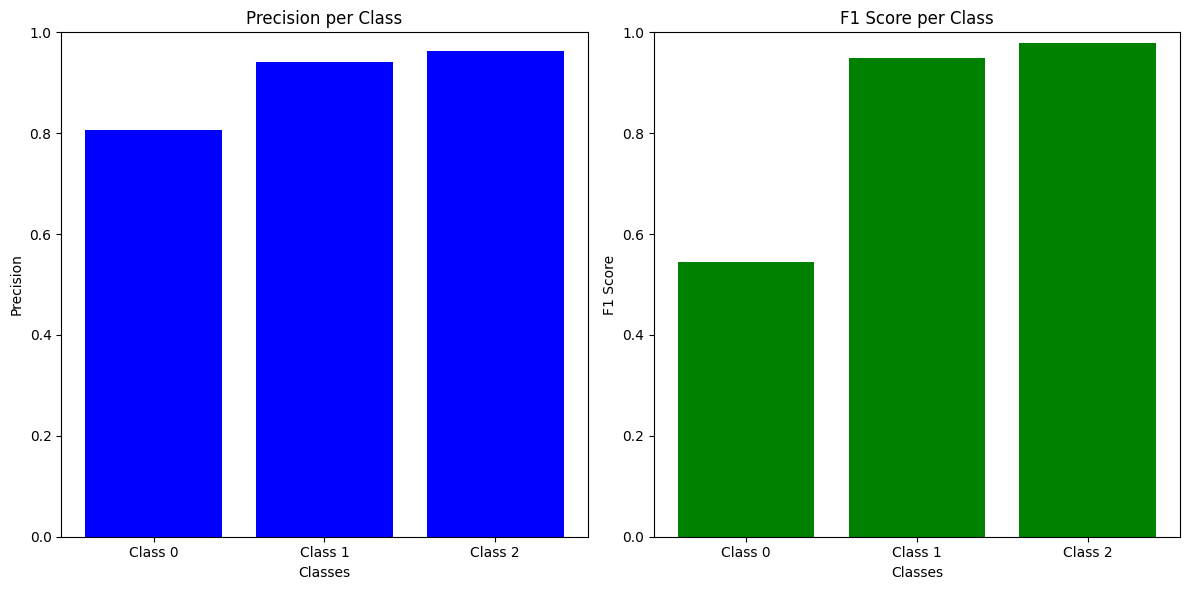

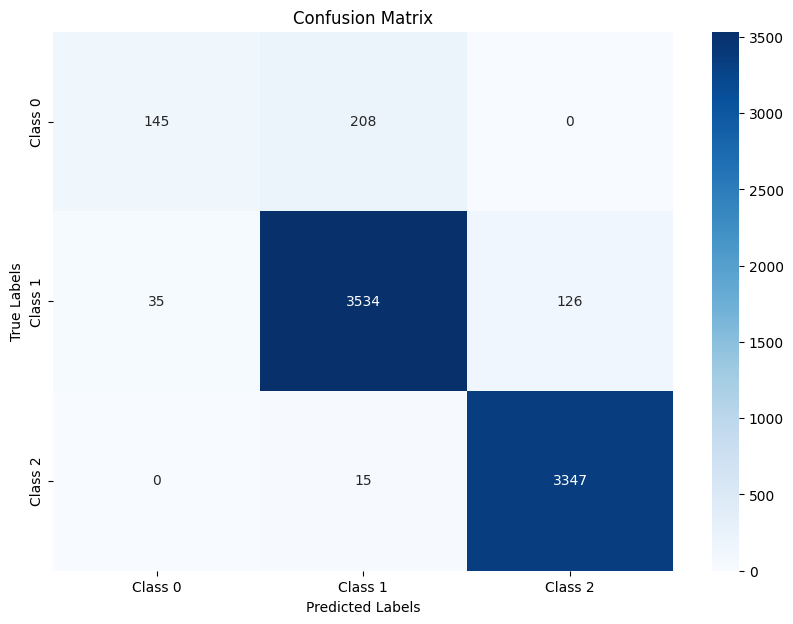

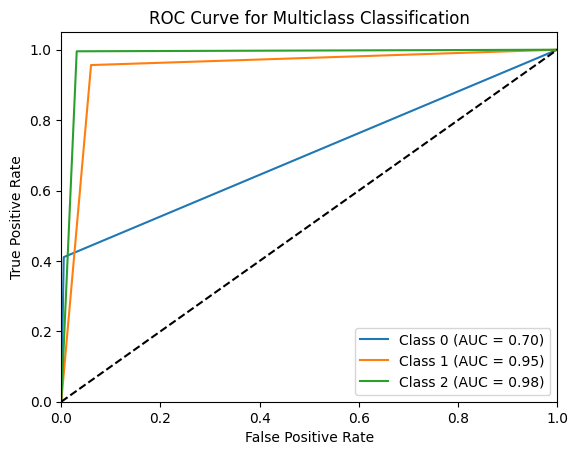

In [25]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


model = model.to(device)  # Move model to the appropriate device

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model.eval()  # Set model to evaluation mode

# Initialize lists to store probabilities and labels
test_probs = []
test_preds = []
test_labels = []
test_label_list = []

# Testing loop
with torch.no_grad():  # Disable gradient computation
    for batch in test_loader:
        # Unpack batch data
        test_features, test_labels = batch
        
        test_features = test_features.to(device).float()
        test_labels = test_labels.to(device)
        
        # Forward pass
        # outputs = model(product_id, category_id, subcategory_id, ratings, no_of_ratings, actual_price, discount_price)
        outputs = model(test_features)
        
        # Apply softmax to get probabilities
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        
        # Store probabilities, predictions, and labels
        test_probs.append(probs.cpu())
        test_preds.append(preds.cpu())
        test_label_list.append(test_labels.cpu())

# Concatenate results across all batches
test_probs = torch.cat(test_probs)
test_preds = torch.cat(test_preds)
test_labels = torch.cat(test_label_list)

# Convert to numpy arrays for metrics calculation and saving
test_probs_np = test_probs.numpy()
test_preds_np = test_preds.numpy()
test_labels_np = test_labels.numpy()


# Calculate metrics
accuracy = accuracy_score(test_labels_np, test_preds_np)
precision = precision_score(test_labels_np, test_preds_np, average='weighted')
recall = recall_score(test_labels_np, test_preds_np, average='weighted')
f1 = f1_score(test_labels_np, test_preds_np, average='weighted')
conf_matrix = confusion_matrix(test_labels_np, test_preds_np)

# Print metrics
print(f'Final Test Metrics:\n')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Create a DataFrame to store results
test_prob_df = pd.DataFrame(test_probs_np, columns=[f'prob_class_{i}' for i in range(test_probs_np.shape[1])])
test_prob_df['predictions'] = test_preds_np
test_prob_df['labels'] = test_labels_np

# Save the results to an Excel file
test_prob_df.to_excel(os.path.join(exp_dir, 'test_data_predictions.xlsx'), index=False)

print('Testing Complete !!!')

# Calculate the AUC for all classes and plot ROC curves
num_classes = test_probs_np.shape[1]
# average_auc = calculate_and_plot_average_auc_roc(test_labels_np, test_probs_np, num_classes)
# print(f'Average AUC: {average_auc:.4f}')

# Print the average AUC
# print(f'Average AUC: {average_auc:.4f}')

plot_precision_f1(test_probs_np, test_labels_np, num_classes=3)

class_names = [f'Class {i}' for i in range(num_classes)]

# plot the confusion matrix
plot_confusion_matrix(test_labels_np, test_preds_np, class_names)

plot_multiclass_roc(test_labels_np, test_preds_np)